## Uncertainty in Explanations via Input Perturbation (Tabular)

Notebook derived from https://colab.research.google.com/drive/1pjDJmAa9oeSquYtbYh6tksU6eTmObIcq

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import seaborn as sns

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [4]:
from xplique.attributions import (Saliency,
                             IntegratedGradients,
                             KernelShap,
                             Lime,
                             Occlusion,
                             SmoothGrad,
                             VarGrad,
                             SquareGrad,
                             GuidedBackprop,
                             DeconvNet,
                             GradientInput)
from xplique.plots import plot_feature_impact, plot_mean_feature_impact, summary_plot_tabular

### Load dataset

In [5]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [6]:
dataset = raw_dataset.copy()
dataset.tail()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
393          82       1  
394          82       2  
395          82       1  
396          82       1  
397          82       1

In [7]:
# the dataset contains na value, we just drop them
dataset = dataset.dropna()
# the origin column is not numeric so we convert it to a one hot-hot
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Europe  Japan  USA  
393          82       0      0    1  
394          82       1      0    0  
395          82       0      0    1  
396          82       0      0    1  
397          82       0      0    1

In [8]:
# Splits
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset  = dataset.drop(train_dataset.index)

In [9]:
# Separate features from labels
train_features = train_dataset.copy()
test_features  = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels  = test_features.pop('MPG')

In [10]:
# Normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features.values)
test_features  = scaler.transform(test_features.values)

In [11]:
inputs_tf, targets_tf = tf.cast(test_features, tf.float32), tf.cast(test_labels, tf.float32)
targets_tf = tf.expand_dims(targets_tf, axis=-1)
new_targets_tf = tf.ones((78,1))
len(targets_tf)

78

In [12]:
features_name = [
    'Cylinders',
    'Displacement',
    'Horsepower',
    'Weight',
    'Acceleration',
    'Model Year',
    'Europe',
    'Japan',
    'USA'
]

### Load/Train Model

In [13]:
# Whether to train a model or load a pretrained one
train_model = False
model_path = './models/ann_tabular.h5'

In [14]:
if train_model:
    # Define a simple ANN
    model = keras.Sequential([
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))

    %%time
    history = model.fit(train_features, train_labels, validation_split=0.2, verbose=0, epochs=100)
    model.save(model_path)
else:
    model = tf.keras.models.load_model(model_path)

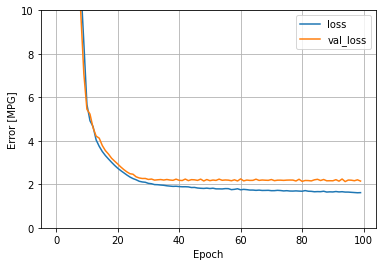

In [11]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)

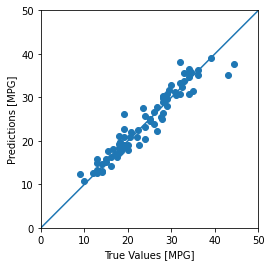

In [12]:
test_predictions = model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

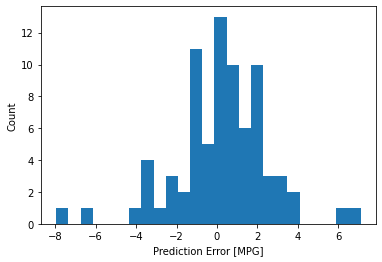

In [13]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

### Explain Model

In [17]:
#explainer = SquareGrad(model)
#explainer = VarGrad(model)
#explainer = SmoothGrad(model)
explainer = Lime(model)
explanation = explainer(inputs_tf, new_targets_tf)

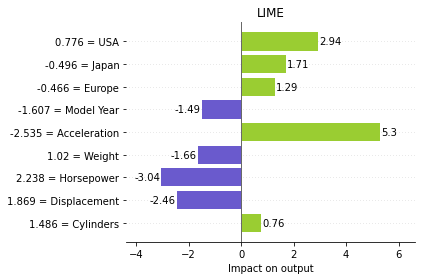

In [18]:
plot_feature_impact(explanation[0], features_name, test_features[0])
plt.title('LIME')
plt.show()

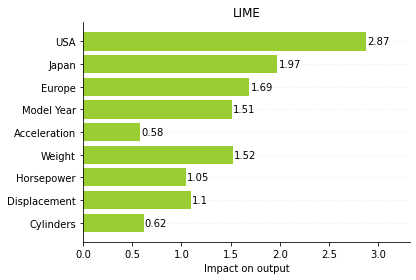

In [19]:
plot_mean_feature_impact(explanation, features_name)
plt.title('LIME')
plt.show()

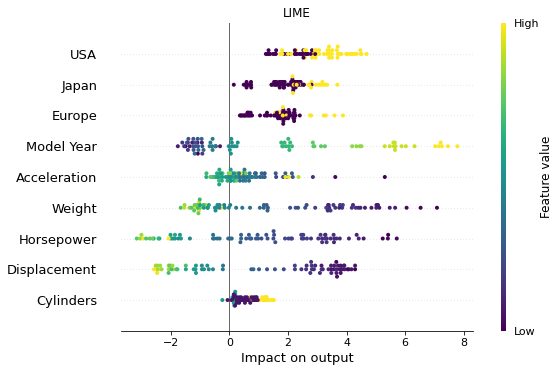

In [20]:
summary_plot_tabular(
    explanation,
    features_values=test_features,
    features_name=features_name
)
plt.title('LIME')
plt.show()

### Compute variance analytically

In [21]:
# Explain one sample
ex_ind = 0
ex_row, ex_target = np.expand_dims(inputs_tf[ex_ind], axis=0), np.expand_dims([1], axis=0)

ex_exp = explainer(ex_row, ex_target)
ex_exp

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[ 0.954, -2.744, -3.384, -1.187,  5.125, -1.324,  1.566,  1.682,
         2.841]], dtype=float32)>

In [22]:
# Compute derivative of explanation w.r.t input via FDM
dx = 1e-2
n, m = ex_row.shape[1], ex_exp.shape[1]
derivative_e_x = np.zeros((m, n))

# For every feature perturbation, we get a new column in the Jacobian
for i in range(n):
    # Perturb current feature
    perturbed_row_pos, perturbed_row_neg = np.copy(ex_row), np.copy(ex_row)
    perturbed_row_pos[0,i] += dx
    perturbed_row_neg[0,i] -= dx

    # Compute explanations for perturbed rows
    perturbed_exp_pos = explainer(perturbed_row_pos, ex_target)
    perturbed_exp_neg = explainer(perturbed_row_neg, ex_target)

    # Compute FDM (central differences)
    derivative_e_x[:, i] = (perturbed_exp_pos - perturbed_exp_neg) / (2*dx)

In [23]:
ex_exp

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[ 0.954, -2.744, -3.384, -1.187,  5.125, -1.324,  1.566,  1.682,
         2.841]], dtype=float32)>

In [24]:
perturbed_exp_pos

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[ 0.915, -2.419, -3.22 , -1.523,  5.09 , -1.167,  1.65 ,  1.58 ,
         3.153]], dtype=float32)>

In [25]:
perturbed_exp_neg

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[ 0.59 , -2.648, -3.383, -1.626,  5.037, -1.402,  1.489,  1.83 ,
         2.834]], dtype=float32)>

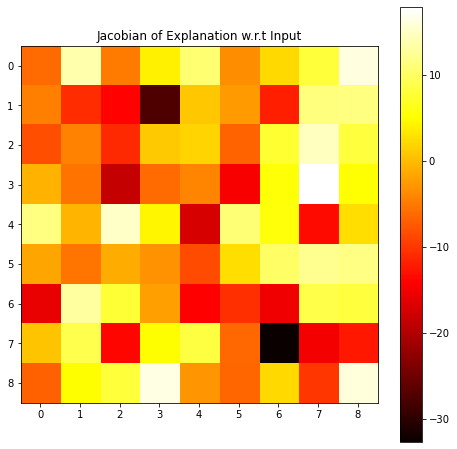

In [26]:
plt.figure(figsize=(8,8))
plt.imshow(derivative_e_x, cmap='hot')
plt.title("Jacobian of Explanation w.r.t Input")
plt.colorbar()
plt.show()

In [27]:
# Approximate covariance of explanation
perturbation_std = 0.1
sigma_squared = perturbation_std ** 2
variance_explanation = sigma_squared * derivative_e_x @ derivative_e_x.T

# Total variance is the trace of the cov. matrix
print("Total Variance of Explanation (Analytical):", np.trace(variance_explanation))

Total Variance of Explanation (Analytical): 91.54565414809241


In [28]:
# Normalized total variance is the trace of the cov. matrix divided by the L2-norm of the unperturbed explanation
print("Normalized Variance of Explanation:", np.trace(variance_explanation) / np.linalg.norm(explanation))

Normalized Variance of Explanation: 1.4269821548619874


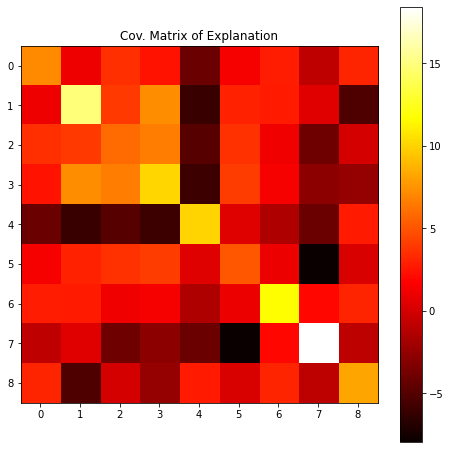

In [29]:
plt.figure(figsize=(8,8))
plt.imshow(variance_explanation, cmap='hot')
plt.title("Cov. Matrix of Explanation")
plt.colorbar()
plt.show()

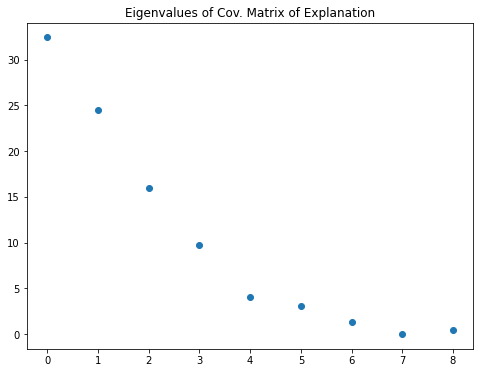

In [30]:
# Explained variance ratio
evals, evecs = np.linalg.eig(variance_explanation)

plt.figure(figsize=(8,6))
plt.plot(evals, 'o')
plt.title('Eigenvalues of Cov. Matrix of Explanation');

### Compute variance empirically

In [31]:
num_perturbations = 10
perturbation_std = 0.1  # same as above for analytical formula
sigma_squared = perturbation_std ** 2

perturbed_explanations = []
for _ in range(num_perturbations):
    # Add Gaussian noise to the input image
    perturbed_row = ex_row + np.random.normal(0, perturbation_std, ex_row.shape)

    # Generate explanation for perturbed input
    perturbed_explanations.append( explainer(perturbed_row, ex_target) )

# Stack explanations and compute covariance matrix
explanation_matrix = np.stack(perturbed_explanations, axis=0).squeeze()
empirical_covariance = np.cov(explanation_matrix, rowvar=False)

# Compute total variance (trace of the covariance matrix)
empirical_total_variance = np.trace(empirical_covariance)

print("Empirical Total Variance of Explanation:", empirical_total_variance)

Empirical Total Variance of Explanation: 0.9752579833016571


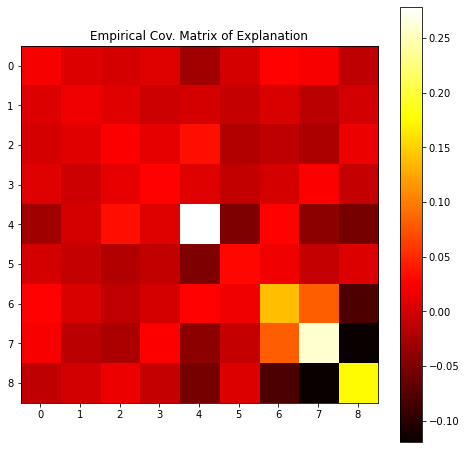

In [32]:
plt.figure(figsize=(8,8))
plt.imshow(empirical_covariance, cmap='hot')
plt.title("Empirical Cov. Matrix of Explanation")
plt.colorbar()
plt.show()

### Analytical vs Empirical (multiple methods, multiple variances)

In [20]:
xai_methods  = {'Saliency': Saliency,
                'GradientInput': GradientInput,
                'IntegratedGradients': IntegratedGradients,
                'GuidedBackprop': GuidedBackprop,
                'Occlusion': lambda model: Occlusion(model, patch_size=1, patch_stride=1),
                #'KernelShap': KernelShap,
                #'Lime': Lime,
                }
#stds = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1] # std. deviations
stds = [0.2, 0.3, 0.4, 0.5]
num_perturbations = 500 #1000 # for empirical cov.
dx = 1e-3 # differential for ana. cov.

#ex_ind = 0 # index of sample to explain
#ex_row, ex_target = np.expand_dims(inputs_tf[ex_ind], axis=0), np.expand_dims([1], axis=0)
n = m = len(features_name)

#ex_inds = [0, 10, 20]
ex_inds = np.arange(10)
#results, cov_mats, empirical_exps, unperturbed_exps = {}, {}, {}, {}
jacobi_mats = {}

for ex_ind in ex_inds:
    # Sample to explain
    ex_row, ex_target = np.expand_dims(inputs_tf[ex_ind], axis=0), np.expand_dims([1], axis=0)
    
    # Store results for plotting
    #results[ex_ind]  = {name: {'analytical': [], 'empirical': []} for name in xai_methods.keys()}
    #cov_mats[ex_ind] = {name: {'analytical': [], 'empirical': []} for name in xai_methods.keys()}
    jacobi_mats[ex_ind] = {}
    #empirical_exps[ex_ind] = {}
    #unperturbed_exps[ex_ind] = {}

    print('\n*********')
    print('Sample ' + str(ex_ind))
    for name, constructor in xai_methods.items():
        print('\n' + name)
        #empirical_exps[ex_ind][name] = {}
        explainer = constructor(model) # instantiate explainer with default params
        explanation = explainer(ex_row, ex_target) # sample explanation
        #unperturbed_exps[ex_ind][name] = explanation

        # Norm of explanation (for normalization of total variance)
        norm_exp_squared = np.linalg.norm(explanation)**2
    
        # Precompute Jacobian (stays fixed for every std)
        derivative_e_x = np.zeros((m, n))
        # For every feature perturbation, we get a new column in the Jacobian
        for i in range(n):
            # Perturb current feature
            perturbed_row = np.copy(ex_row)
            perturbed_row[0,i] += dx
        
            # Compute explanations for perturbed rows
            perturbed_exp = explainer(perturbed_row, ex_target)
        
            # Compute FDM (central differences)
            derivative_e_x[:, i] = (perturbed_exp - explanation) / dx
        jacobi_mats[ex_ind][name] = derivative_e_x
        
        for std in stds:
            ### Analytical
            sigma_squared = std ** 2
            covariance_ana = sigma_squared * derivative_e_x @ derivative_e_x.T
            
            # Total variance is the trace of the cov. matrix
            total_var = np.trace(covariance_ana)/norm_exp_squared
            #print("Analytical Variance (std = ", std, "):", total_var)
            results[ex_ind][name]['analytical'].append(total_var)
            cov_mats[ex_ind][name]['analytical'].append(covariance_ana)
            
            ### Empirical
            perturbed_explanations = []
            for _ in range(num_perturbations):
                # Add Gaussian noise to the input image
                perturbed_row = ex_row + np.random.normal(0, std, ex_row.shape)
            
                # Generate explanation for perturbed input
                perturbed_explanations.append( explainer(perturbed_row, ex_target) )
            
            # Stack explanations and compute covariance matrix
            explanation_matrix = np.stack(perturbed_explanations, axis=0).squeeze()
            covariance_emp = np.cov(explanation_matrix, rowvar=False)

            total_var = np.trace(covariance_emp)/norm_exp_squared
            #print("Empirical Variance (std = ", std, "):", total_var)
            results[ex_ind][name]['empirical'].append(total_var)
            cov_mats[ex_ind][name]['empirical'].append(covariance_emp)
            
            # Store explanations for normality checks
            empirical_exps[ex_ind][name][std] = np.stack(perturbed_explanations, axis=0)


*********
Sample 0

Saliency

GradientInput

IntegratedGradients

GuidedBackprop

Occlusion

*********
Sample 1

Saliency

GradientInput

IntegratedGradients

GuidedBackprop

Occlusion

*********
Sample 2

Saliency

GradientInput

IntegratedGradients

GuidedBackprop

Occlusion

*********
Sample 3

Saliency

GradientInput

IntegratedGradients

GuidedBackprop

Occlusion

*********
Sample 4

Saliency

GradientInput

IntegratedGradients

GuidedBackprop

Occlusion

*********
Sample 5

Saliency

GradientInput

IntegratedGradients

GuidedBackprop

Occlusion

*********
Sample 6

Saliency

GradientInput

IntegratedGradients

GuidedBackprop

Occlusion

*********
Sample 7

Saliency

GradientInput

IntegratedGradients

GuidedBackprop

Occlusion

*********
Sample 8

Saliency

GradientInput

IntegratedGradients

GuidedBackprop

Occlusion

*********
Sample 9

Saliency

GradientInput

IntegratedGradients

GuidedBackprop

Occlusion


In [21]:
# Store expriment dictionaries
import pickle
#experiments = {'results': results, 
#               'cov_mats': cov_mats, 
#               'jacobi_mats': jacobi_mats,
#               'empirical_exps': empirical_exps, 
#               'unperturbed_exps': unperturbed_exps}

#with open('./experiments/experiments_input_tabular_10ex_500pert.pickle', 'wb') as handle:
#    pickle.dump(experiments, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('./experiments/experiments_input_tabular_10ex_500pert.pickle', 'rb') as handle:
    experiments = pickle.load(handle)
#results = experiments['results']
#cov_mats = experiments['cov_mats']
#jacobi_mats = experiments['jacobi_mats']
#empirical_exps = experiments['empirical_exps']
#unperturbed_exps = experiments['unperturbed_exps']

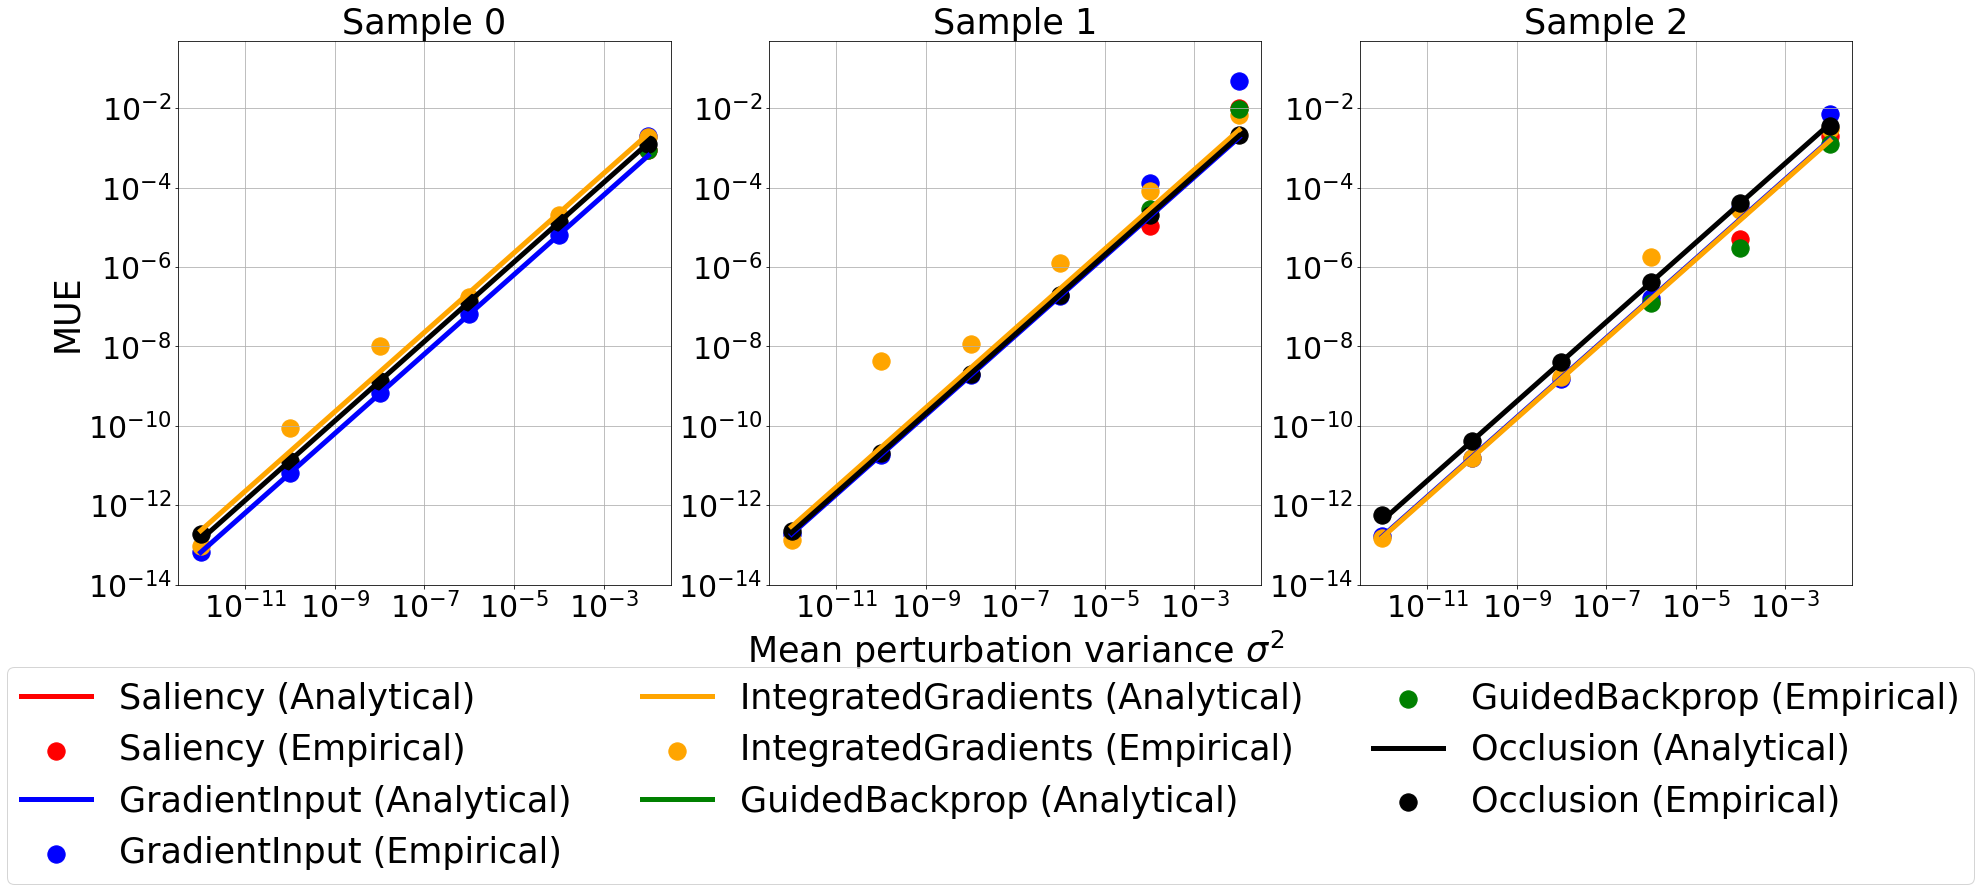

In [30]:
# Plot several samples
colors=['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
stds = np.asarray([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
fsize=35
fig = plt.figure(figsize=(30, 10))
for i, sample_id in enumerate([0,1,2]): 
    plt.subplot(1, 3, i+1)
    for (name, data), col in zip(experiments['results'][sample_id].items(), colors):
        plt.plot(stds*stds, np.asarray(data['analytical'])[:len(stds)]/m, label=f"{name} (Analytical)", c=col, lw=5)
        plt.scatter(stds*stds, np.asarray(data['empirical'])[:len(stds)]/m, marker='o', 
                    label=f"{name} (Empirical)", c=col, s=300)
    plt.title('Sample ' + str(sample_id), fontsize=fsize)
    if i==1: plt.xlabel('Mean perturbation variance $\sigma^2$', fontsize=fsize)
    if i==0: plt.ylabel('MUE', fontsize=fsize)
    plt.xscale('log');plt.yscale('log')
    plt.xticks(fontsize=fsize-5);plt.yticks(fontsize=fsize-5)
    plt.ylim([1e-14, 5e-1])
    if i==2: plt.legend(fontsize=fsize, loc='upper center', bbox_to_anchor=(-0.75, -0.12), ncol=3)
    plt.grid(True)
plt.show()
fig.savefig('./figures/uncertainties_input_tabular.png', bbox_inches='tight')

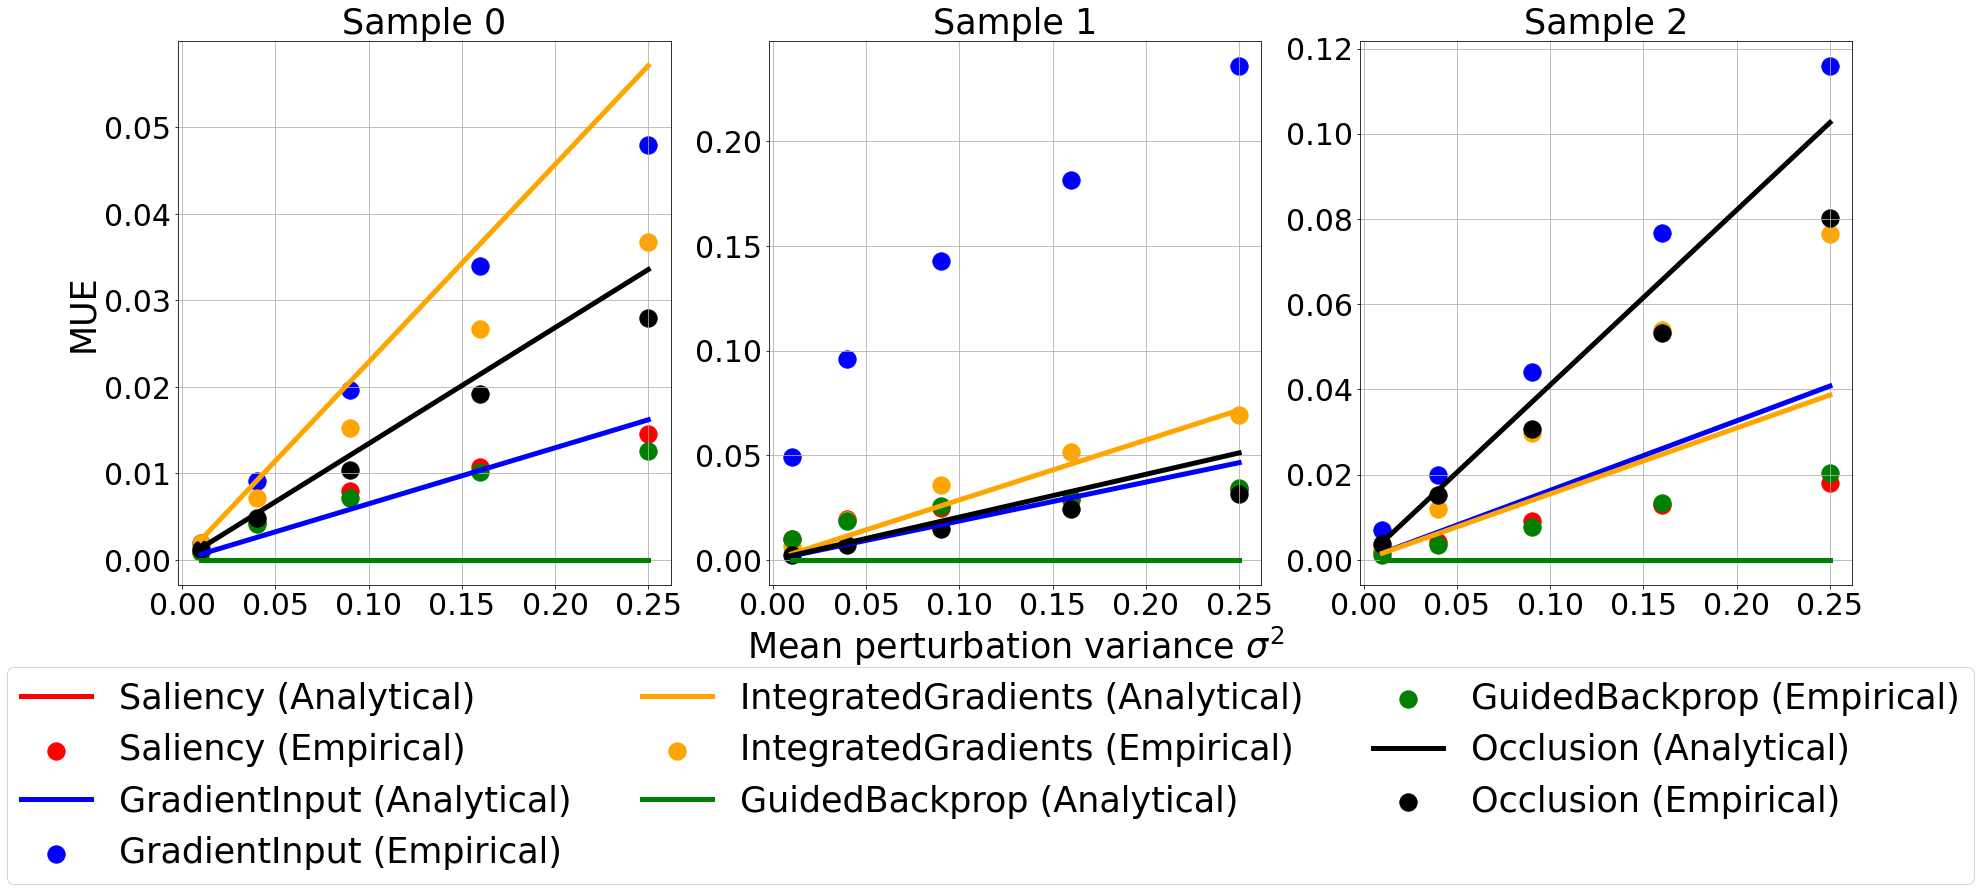

In [31]:
# Plot several samples
colors=['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
stds = np.asarray([0.1, 0.2, 0.3, 0.4, 0.5])
fsize=35
fig = plt.figure(figsize=(30, 10))
for i, sample_id in enumerate([0,1,2]): 
    plt.subplot(1, 3, i+1)
    for (name, data), col in zip(experiments['results'][sample_id].items(), colors):
        plt.plot(stds*stds, np.asarray(data['analytical'])[-len(stds):]/m, label=f"{name} (Analytical)", c=col, lw=5)
        plt.scatter(stds*stds, np.asarray(data['empirical'])[-len(stds):]/m,  marker='o', label=f"{name} (Empirical)", c=col, s=300)
    plt.title('Sample ' + str(sample_id), fontsize=fsize)
    if i==1: plt.xlabel('Mean perturbation variance $\sigma^2$', fontsize=fsize)
    if i==0: plt.ylabel('MUE', fontsize=fsize)
    plt.xticks(fontsize=fsize-5);plt.yticks(fontsize=fsize-5)
    #plt.ylim([-1e-2, 1.0])
    if i==2: plt.legend(fontsize=fsize, loc='upper center', bbox_to_anchor=(-0.75, -0.12), ncol=3)
    plt.grid(True)
plt.show()
fig.savefig('./figures/uncertainties_input_tabular_extended.png', bbox_inches='tight')

In [32]:
# Aggregate results
agg_results = {name: {'analytical': [], 'empirical': []} for name in xai_methods.keys()}
stds = np.asarray([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.2, 0.3, 0.4, 0.5])
for name in xai_methods.keys():
    agg_sum = np.zeros(len(stds))
    for ex_ind in ex_inds:
        agg_sum += experiments['results'][ex_ind][name]['analytical']
    agg_results[name]['analytical'] = agg_sum/len(ex_inds)

    agg_sum = np.zeros(len(stds))
    for ex_ind in ex_inds:
        agg_sum += experiments['results'][ex_ind][name]['empirical']
    agg_results[name]['empirical'] = agg_sum/len(ex_inds)
#agg_results

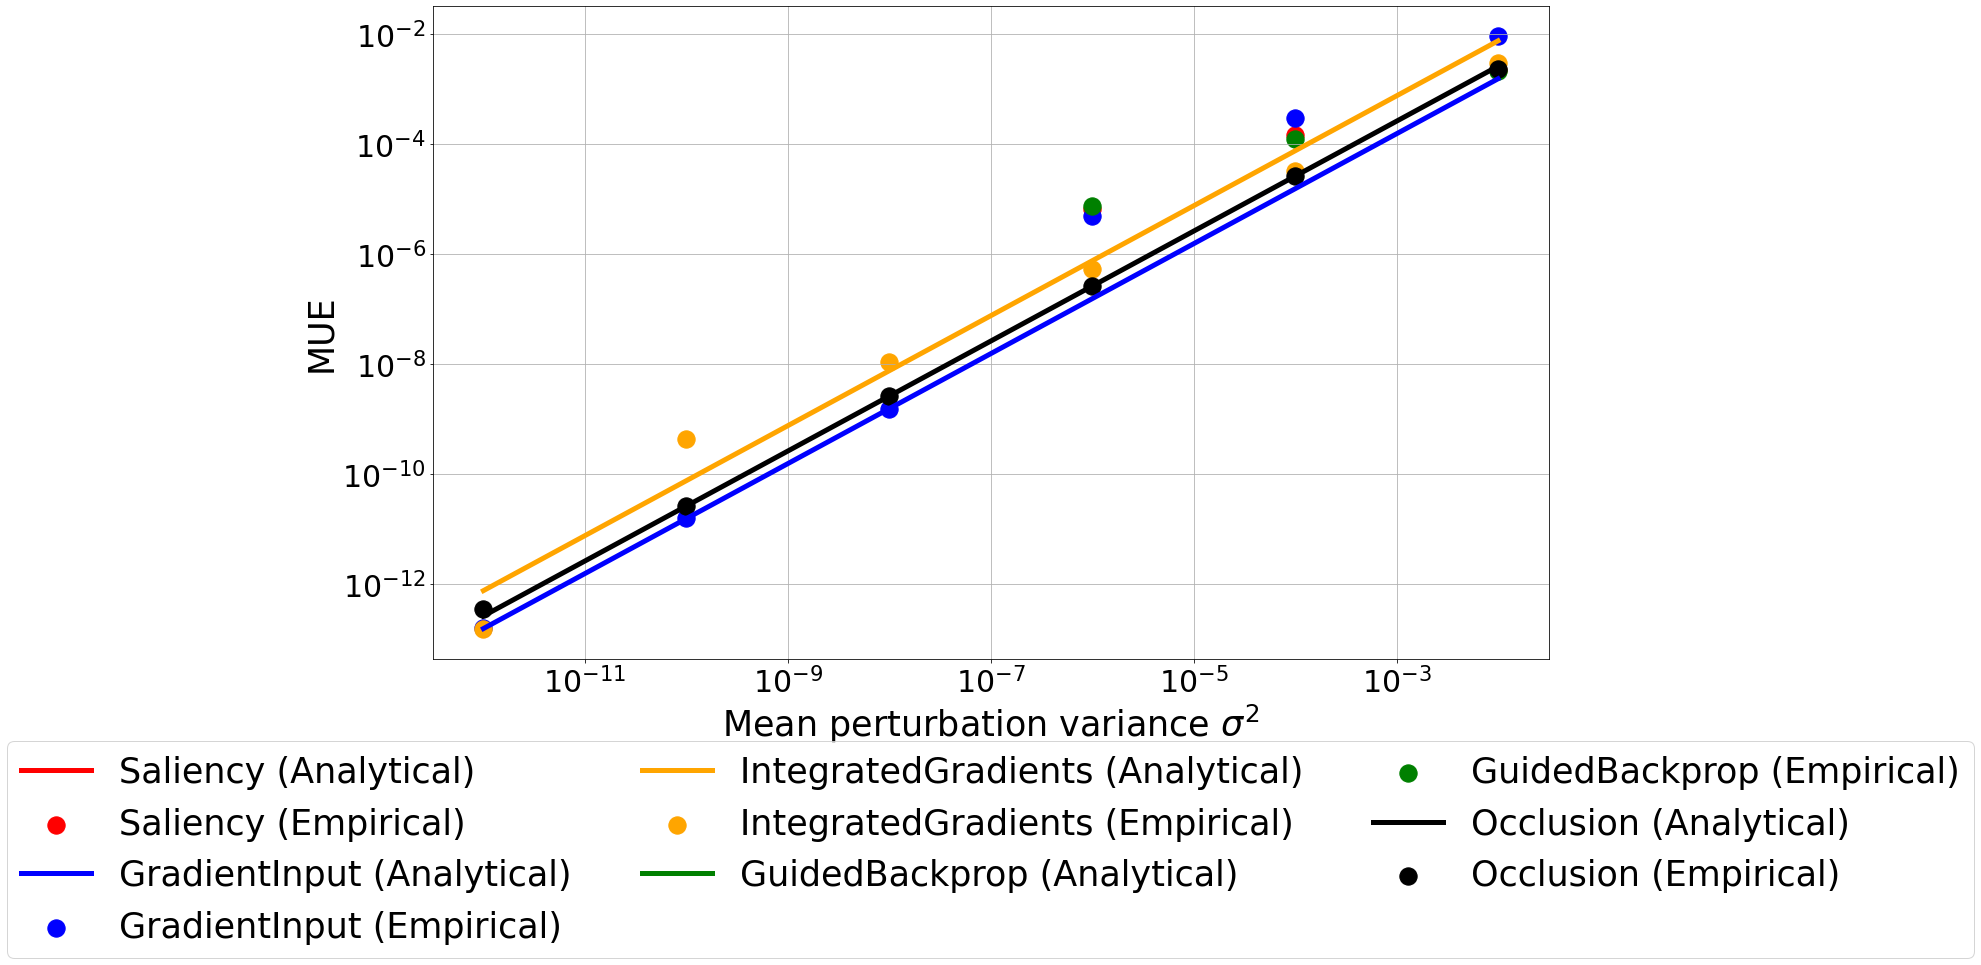

In [33]:
# Plot aggregations
colors=['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
stds = np.asarray([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
fsize=35
fig = plt.figure(figsize=(20, 12))
for (name, data), col in zip(agg_results.items(), colors):
    plt.plot(stds*stds, np.asarray(data['analytical'])[:len(stds)]/m, label=f"{name} (Analytical)", c=col, lw=5)
    plt.scatter(stds*stds, np.asarray(data['empirical'])[:len(stds)]/m,  marker='o', 
                label=f"{name} (Empirical)", c=col, s=300)
plt.xlabel('Mean perturbation variance $\sigma^2$', fontsize=fsize)
plt.ylabel('MUE', fontsize=fsize)
plt.xscale('log');plt.yscale('log')
plt.xticks(fontsize=fsize-5);plt.yticks(fontsize=fsize-5)
plt.legend(fontsize=fsize, loc='upper center', bbox_to_anchor=(0.5, -0.1), 
           ncol=3)
plt.grid(True)
plt.show()
fig.savefig('./figures/uncertainties_input_tabular_agg.png', bbox_inches='tight')

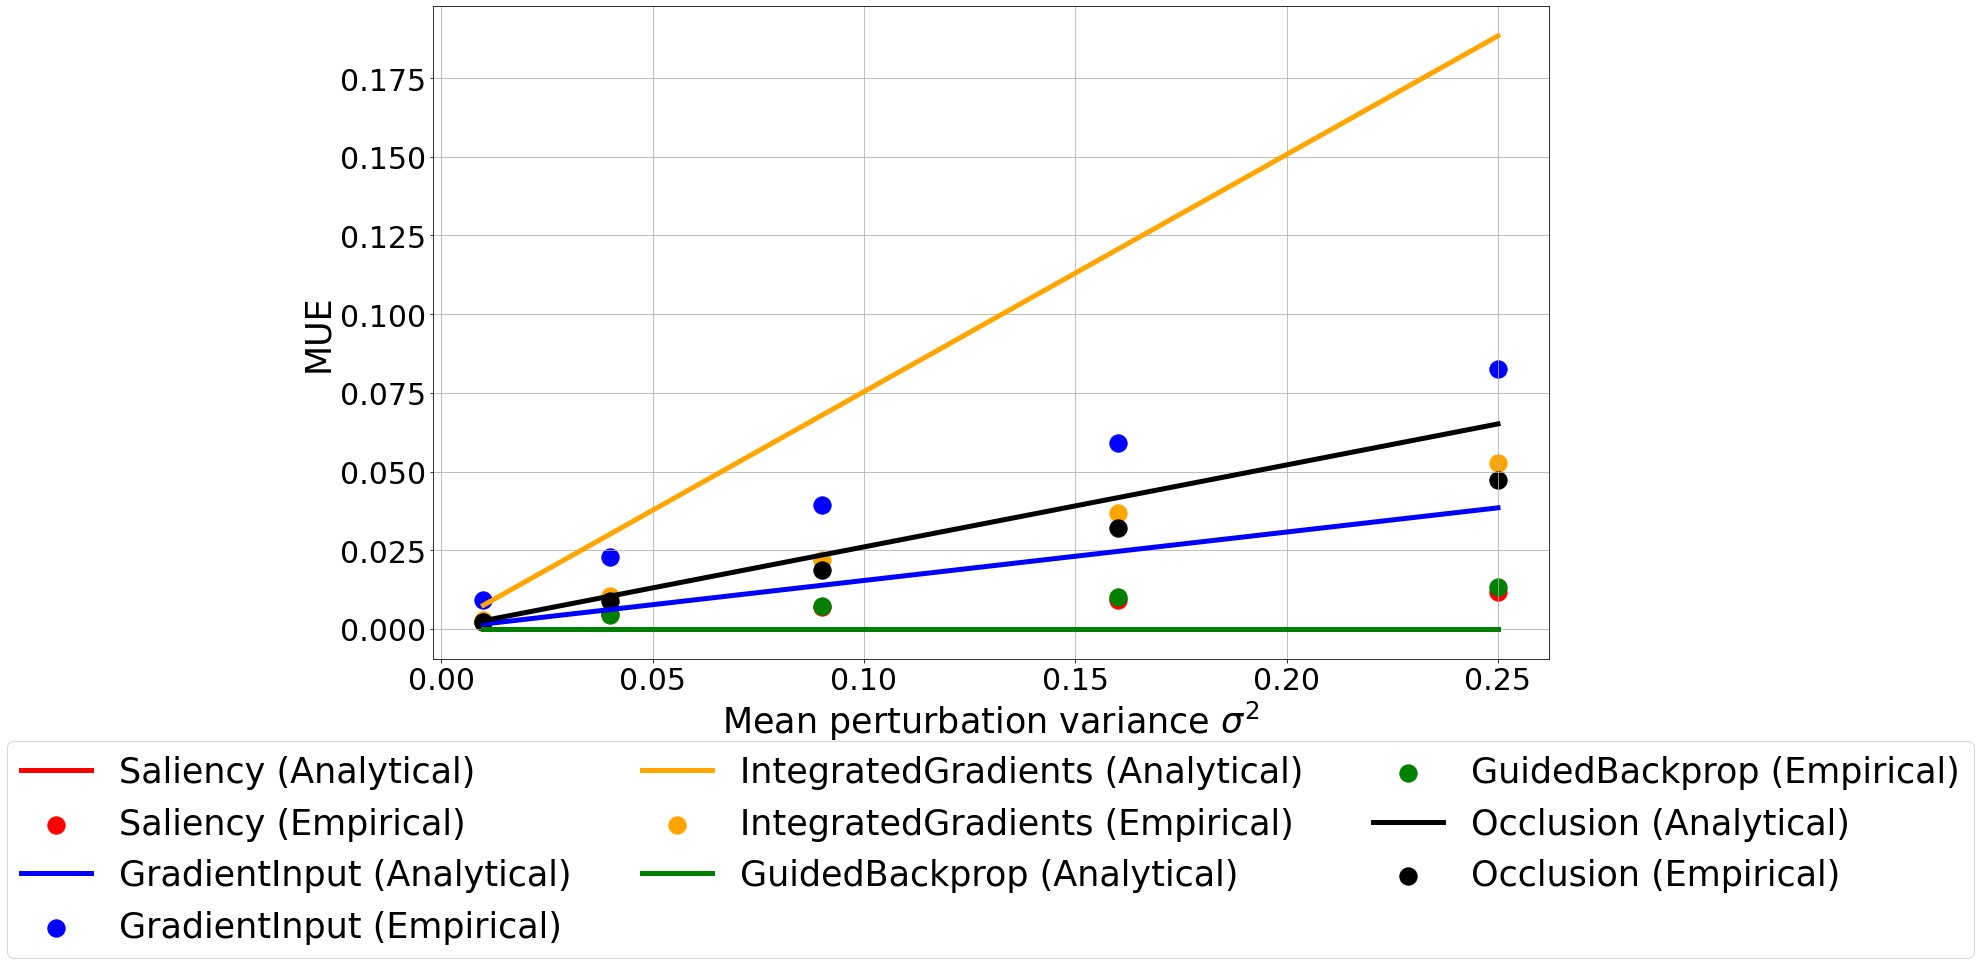

In [34]:
# Plot aggregations
colors=['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
stds = np.asarray([0.1, 0.2, 0.3, 0.4, 0.5])
fsize=35
fig = plt.figure(figsize=(20, 12))
for (name, data), col in zip(agg_results.items(), colors):
    plt.plot(stds*stds, np.asarray(data['analytical'])[-len(stds):]/m, label=f"{name} (Analytical)", c=col, lw=5)
    plt.scatter(stds*stds, np.asarray(data['empirical'])[-len(stds):]/m,  marker='o', 
                label=f"{name} (Empirical)", c=col, s=300)
plt.xlabel('Mean perturbation variance $\sigma^2$', fontsize=fsize)
plt.ylabel('MUE', fontsize=fsize)
plt.xticks(fontsize=fsize-5);plt.yticks(fontsize=fsize-5)
plt.legend(fontsize=fsize, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.grid(True)
plt.show()
fig.savefig('./figures/uncertainties_input_tabular_agg_extended.png', bbox_inches='tight')

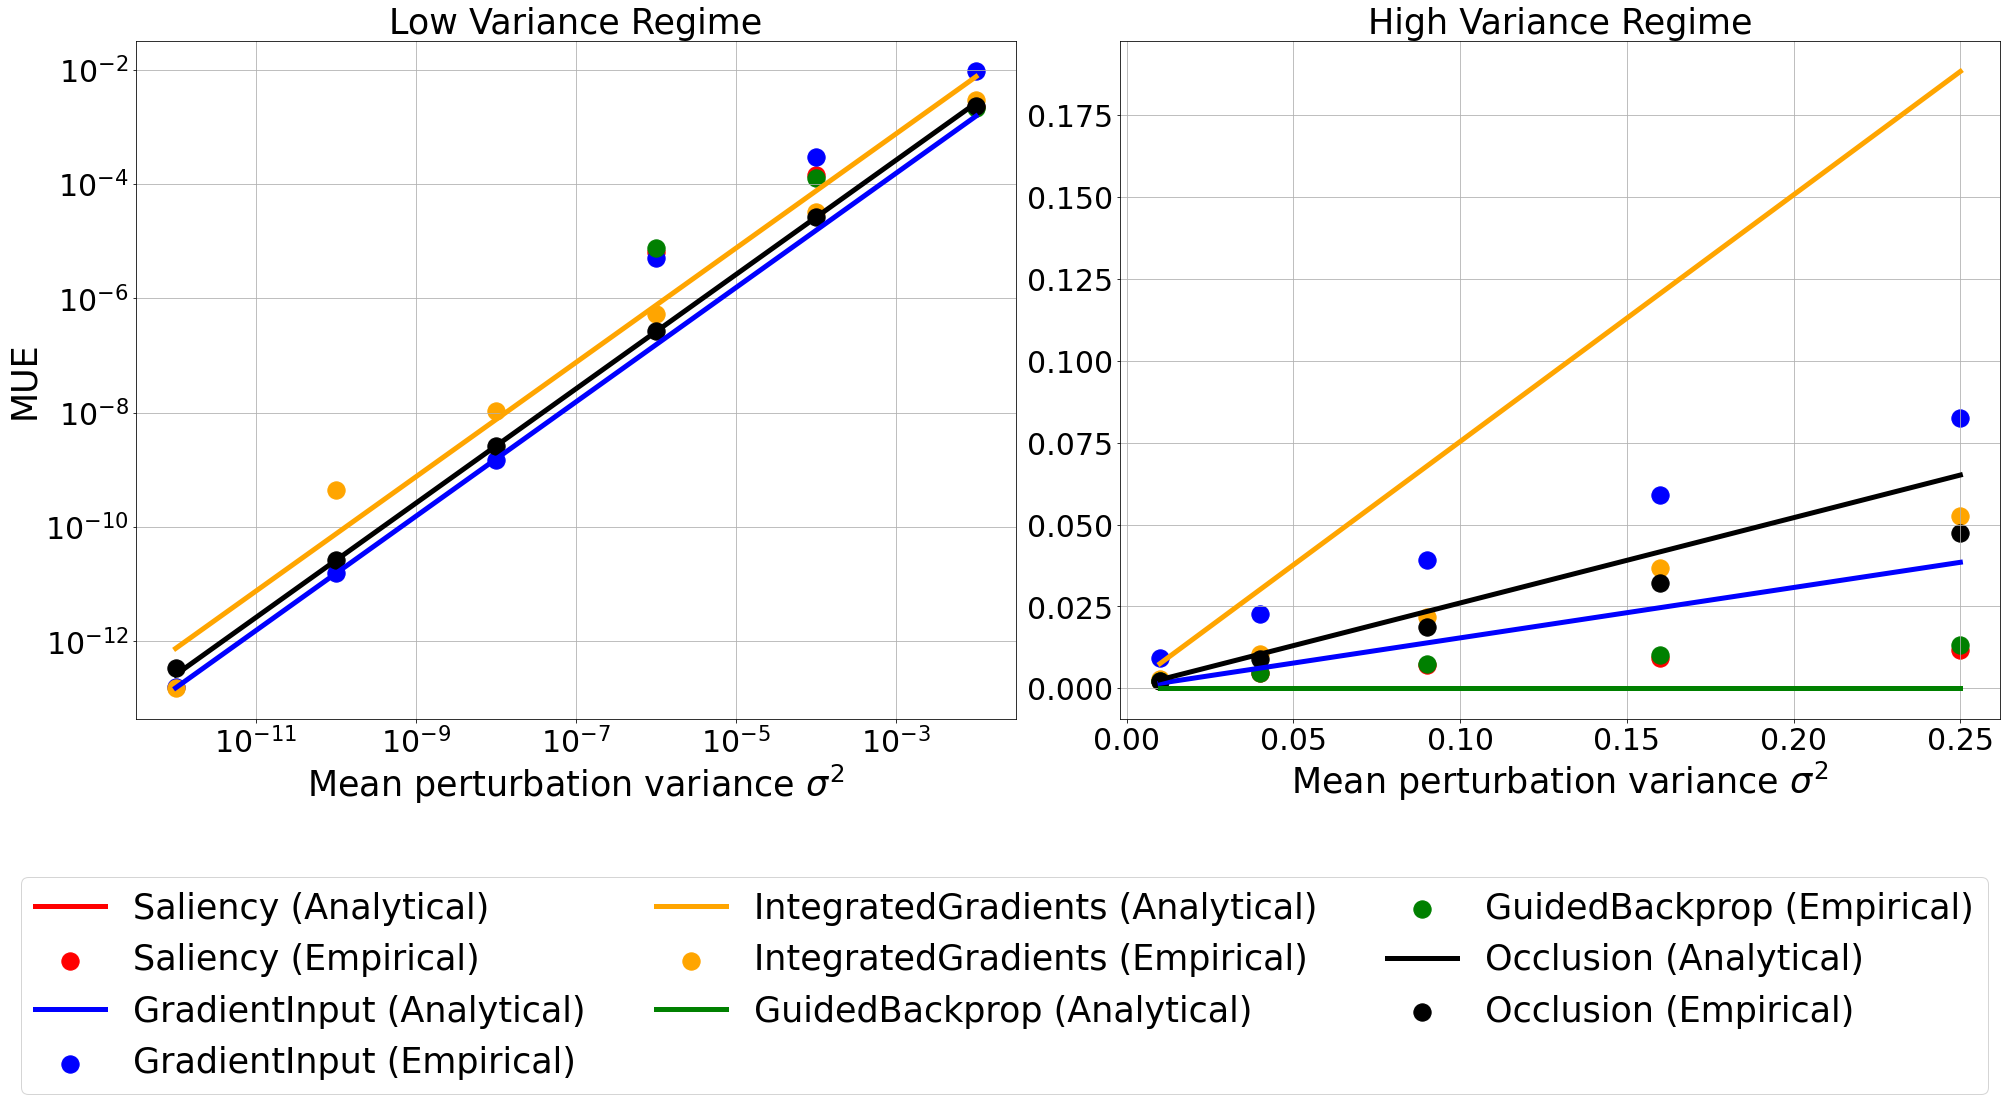

In [38]:
# Define parameters
colors = ['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
fsize = 35

# Define standard deviations for both plots
stds1 = np.asarray([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
stds2 = np.asarray([0.1, 0.2, 0.3, 0.4, 0.5])

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(28, 12))#, sharey=True)

# Plot first subplot
ax = axes[0]
for (name, data), col in zip(agg_results.items(), colors):
    ax.plot(stds1 * stds1, np.asarray(data['analytical'])[:len(stds1)] / m, label=f"{name} (Analytical)", c=col, lw=5)
    ax.scatter(stds1 * stds1, np.asarray(data['empirical'])[:len(stds1)] / m, marker='o', label=f"{name} (Empirical)", c=col, s=300)
ax.set_xlabel('Mean perturbation variance $\sigma^2$', fontsize=fsize)
ax.set_ylabel('MUE', fontsize=fsize)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=fsize-5)
ax.grid(True)
ax.set_title("Low Variance Regime", fontsize=fsize)

# Plot second subplot
ax = axes[1]
for (name, data), col in zip(agg_results.items(), colors):
    ax.plot(stds2 * stds2, np.asarray(data['analytical'])[-len(stds2):] / m, label=f"{name} (Analytical)", c=col, lw=5)
    ax.scatter(stds2 * stds2, np.asarray(data['empirical'])[-len(stds2):] / m, marker='o', label=f"{name} (Empirical)", c=col, s=300)
ax.set_xlabel('Mean perturbation variance $\sigma^2$', fontsize=fsize)
ax.tick_params(axis='both', which='major', labelsize=fsize-5)
ax.grid(True)
ax.set_title("High Variance Regime", fontsize=fsize)

# Create a single legend below both plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, fontsize=fsize, loc='upper center', bbox_to_anchor=(0.5, -0.0), ncol=3)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()
fig.savefig('./figures/uncertainties_input_tabular_agg_combi.png', bbox_inches='tight')


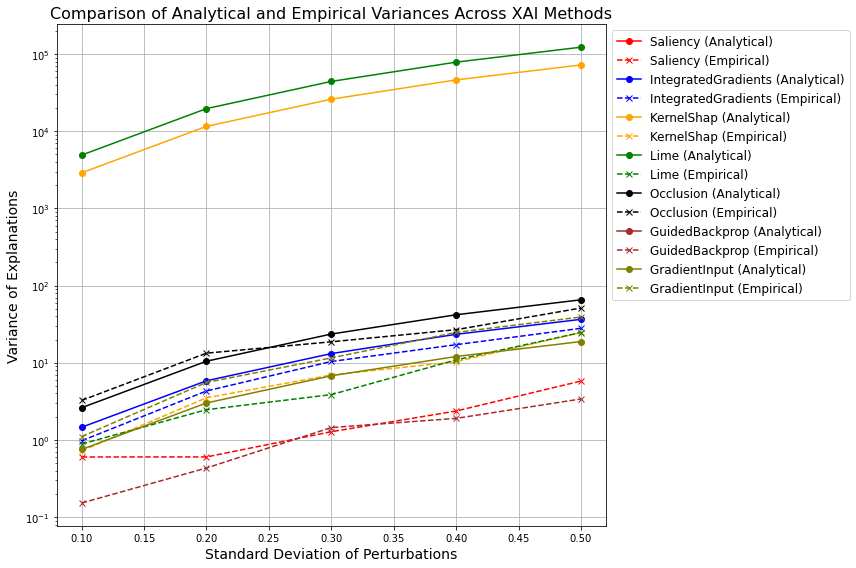

In [38]:
plt.figure(figsize=(12, 8))
colors=['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
for (name, data), col in zip(results.items(), colors):
    plt.plot(stds, data['analytical'], marker='o', label=f"{name} (Analytical)", c=col)
    plt.plot(stds, data['empirical'],  marker='x', label=f"{name} (Empirical)", c=col, linestyle='dashed')

plt.xlabel('Standard Deviation of Perturbations', fontsize=14)
plt.yscale('log')
plt.ylabel('Variance of Explanations', fontsize=14)
plt.title('Comparison of Analytical and Empirical Variances Across XAI Methods', fontsize=16)
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

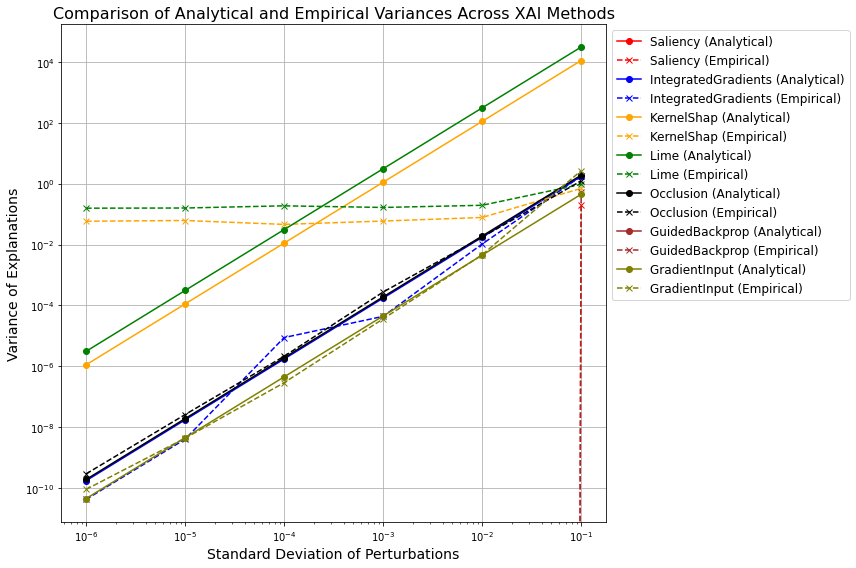

In [24]:
plt.figure(figsize=(12, 8))
colors=['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
for (name, data), col in zip(results.items(), colors):
    plt.plot(stds, data['analytical'], marker='o', label=f"{name} (Analytical)", c=col)
    plt.plot(stds, data['empirical'],  marker='x', label=f"{name} (Empirical)", c=col, linestyle='dashed')

plt.xlabel('Standard Deviation of Perturbations', fontsize=14);plt.xscale('log')
plt.ylabel('Variance of Explanations', fontsize=14);plt.yscale('log')
plt.title('Comparison of Analytical and Empirical Variances Across XAI Methods', fontsize=16)
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

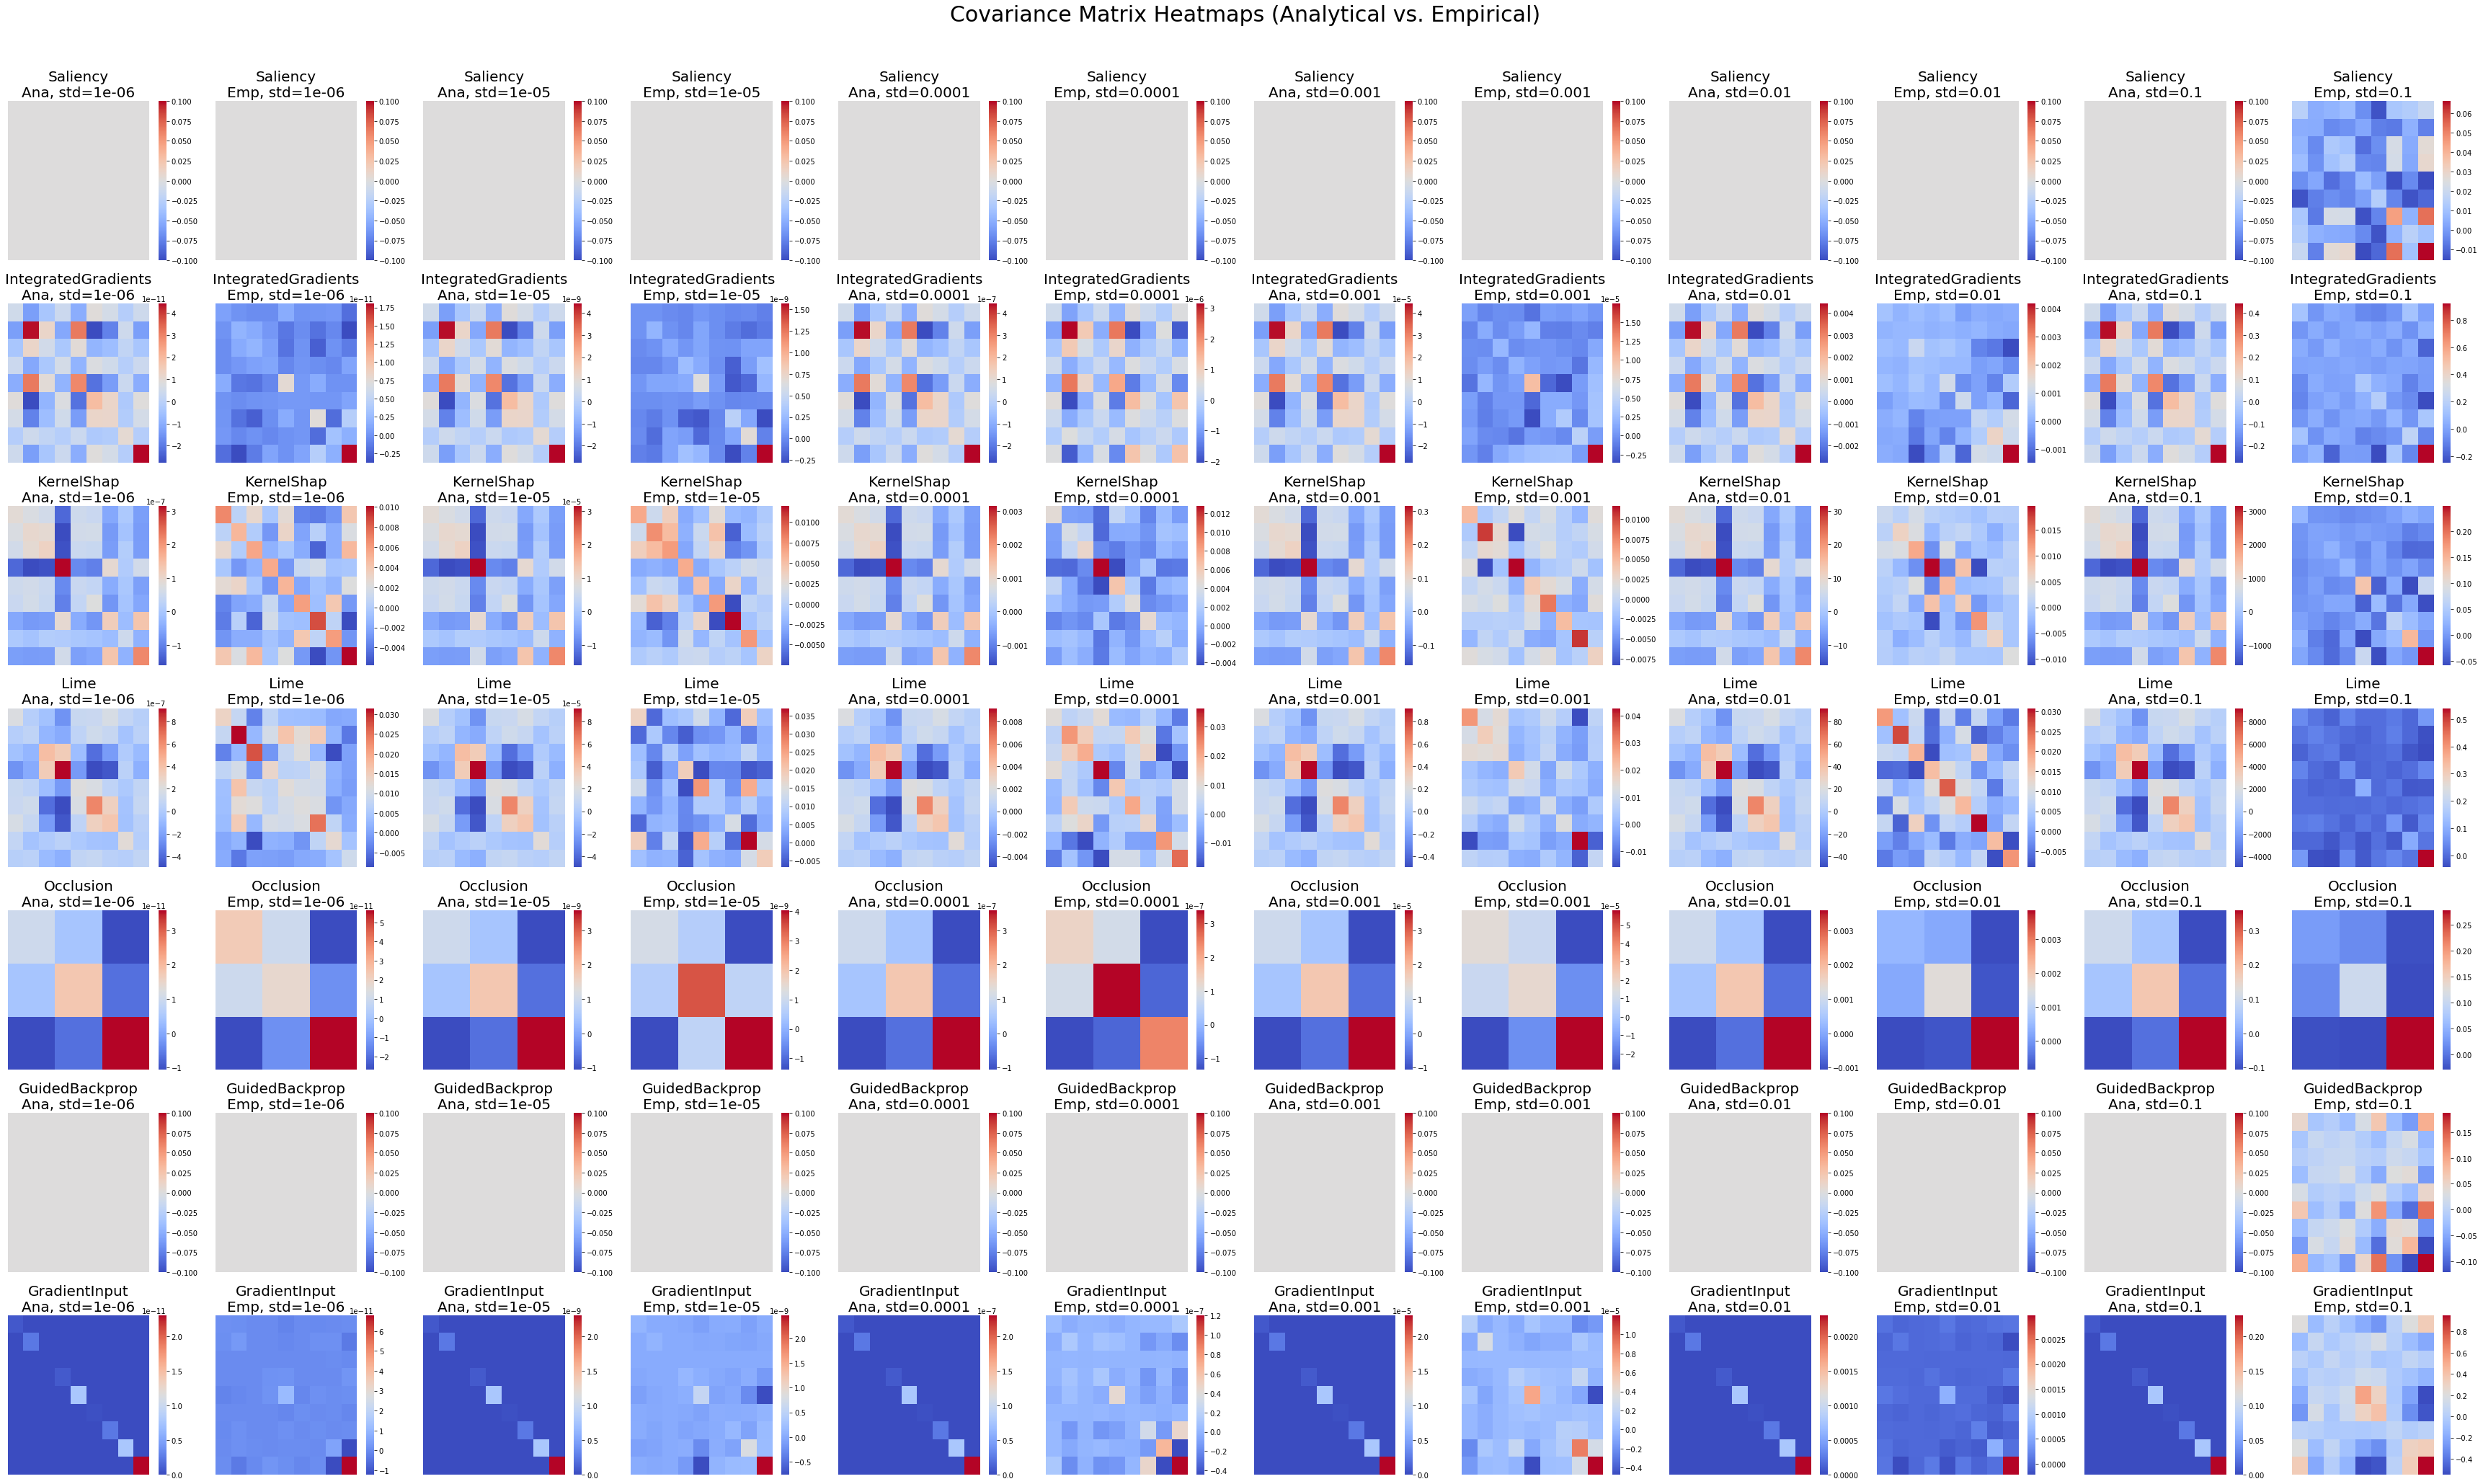

In [25]:
# Create heatmaps for all methods and perturbation stds
# Note: it may take 2 mins to display
def plot_heatmaps(cov_mats, stds):
    num_methods = len(cov_mats)
    num_stds = len(stds)

    fig, axes = plt.subplots(num_methods, num_stds * 2, figsize=(4 * num_stds * 2, 4 * num_methods))
    fig.suptitle('Covariance Matrix Heatmaps (Analytical vs. Empirical)', fontsize=30, y=1.02)

    for i, (name, cov_data) in enumerate(cov_mats.items()):
        for j, std in enumerate(stds):
            # Analytical covariance matrix
            cov_ana = cov_data['analytical'][j]
            ax = axes[i, j * 2]
            sns.heatmap(cov_ana, ax=ax, cmap="coolwarm", xticklabels=False, yticklabels=False, cbar=True)
            ax.set_title(f"{name}\nAna, std={std}", fontsize=20)
            ax.tick_params(left=False, bottom=False)

            # Empirical covariance matrix
            cov_emp = cov_data['empirical'][j]
            ax = axes[i, j * 2 + 1]
            sns.heatmap(cov_emp, ax=ax, cmap="coolwarm", xticklabels=False, yticklabels=False, cbar=True)
            ax.set_title(f"{name}\nEmp, std={std}", fontsize=20)
            ax.tick_params(left=False, bottom=False)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Call the function to generate heatmaps
plot_heatmaps(cov_mats, stds)

### Normality Checks

C:\Users\Teo\anaconda3\envs\tf2_gpu\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Teo\anaconda3\envs\tf2_gpu\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Teo\anaconda3\envs\tf2_gpu\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Teo\anaconda3\envs\tf2_gpu\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Teo\anaconda3\envs\tf2_gpu\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


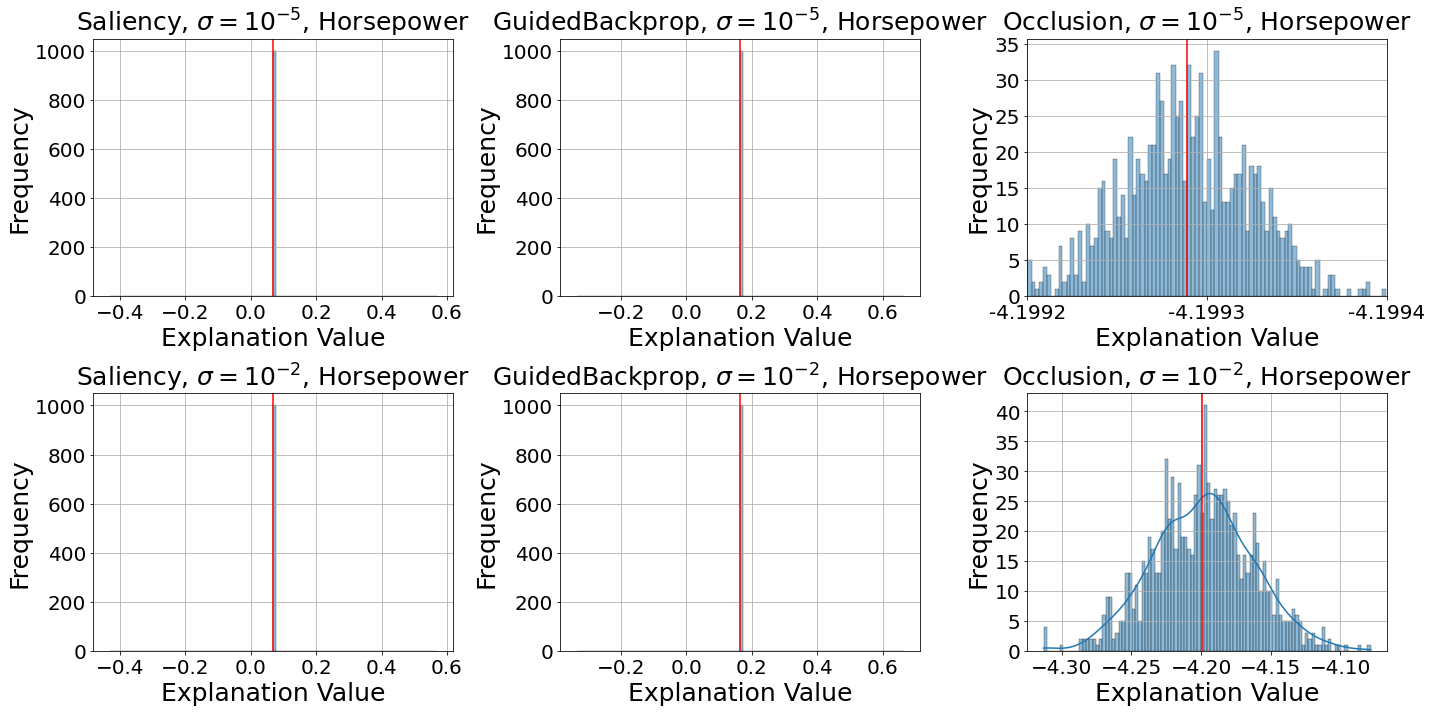

In [37]:
# Plot histogram and Kernel Density Estimate (KDE)
sample_id, feature_id = 0, 2
fsize = 25
fig = plt.figure(figsize=(20, 10))
#fig.suptitle('Distributions perturbed explanations for sample ' + str(sample_id), fontsize=20)
for i, exp_name in enumerate(['Saliency', 'GuidedBackprop', 'Occlusion']): 
    for j, std in enumerate([1e-5, 1e-2]):
        plt.subplot(2,3,3*j+i+1)
        sns.histplot(experiments['empirical_exps'][sample_id][exp_name][std][:,0,feature_id], kde=True, bins=100)
        plt.axvline(x=experiments['unperturbed_exps'][sample_id][exp_name][0][feature_id], color='r')#, label='axvline - full height')
        plt.title(exp_name + ', $\sigma=10^{' + str(int(np.log10(std))) + '}$, ' + features_name[feature_id], fontsize=fsize)
        if i == 2 and j == 0: 
            plt.xlim([-4.1993-1e-4, -4.1993+1e-4])
            plt.xticks([-4.1993-1e-4, -4.1993, -4.1993+1e-4], labels=['-4.1992', '-4.1993', '-4.1994'])
        plt.xlabel("Explanation Value", fontsize=fsize); plt.xticks(fontsize=fsize-5)
        plt.ylabel("Frequency", fontsize=fsize); plt.yticks(fontsize=fsize-5)
        plt.grid()
plt.tight_layout()
fig.savefig('./figures/input_tabular_normality.png', bbox_inches='tight')
plt.show()

c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\

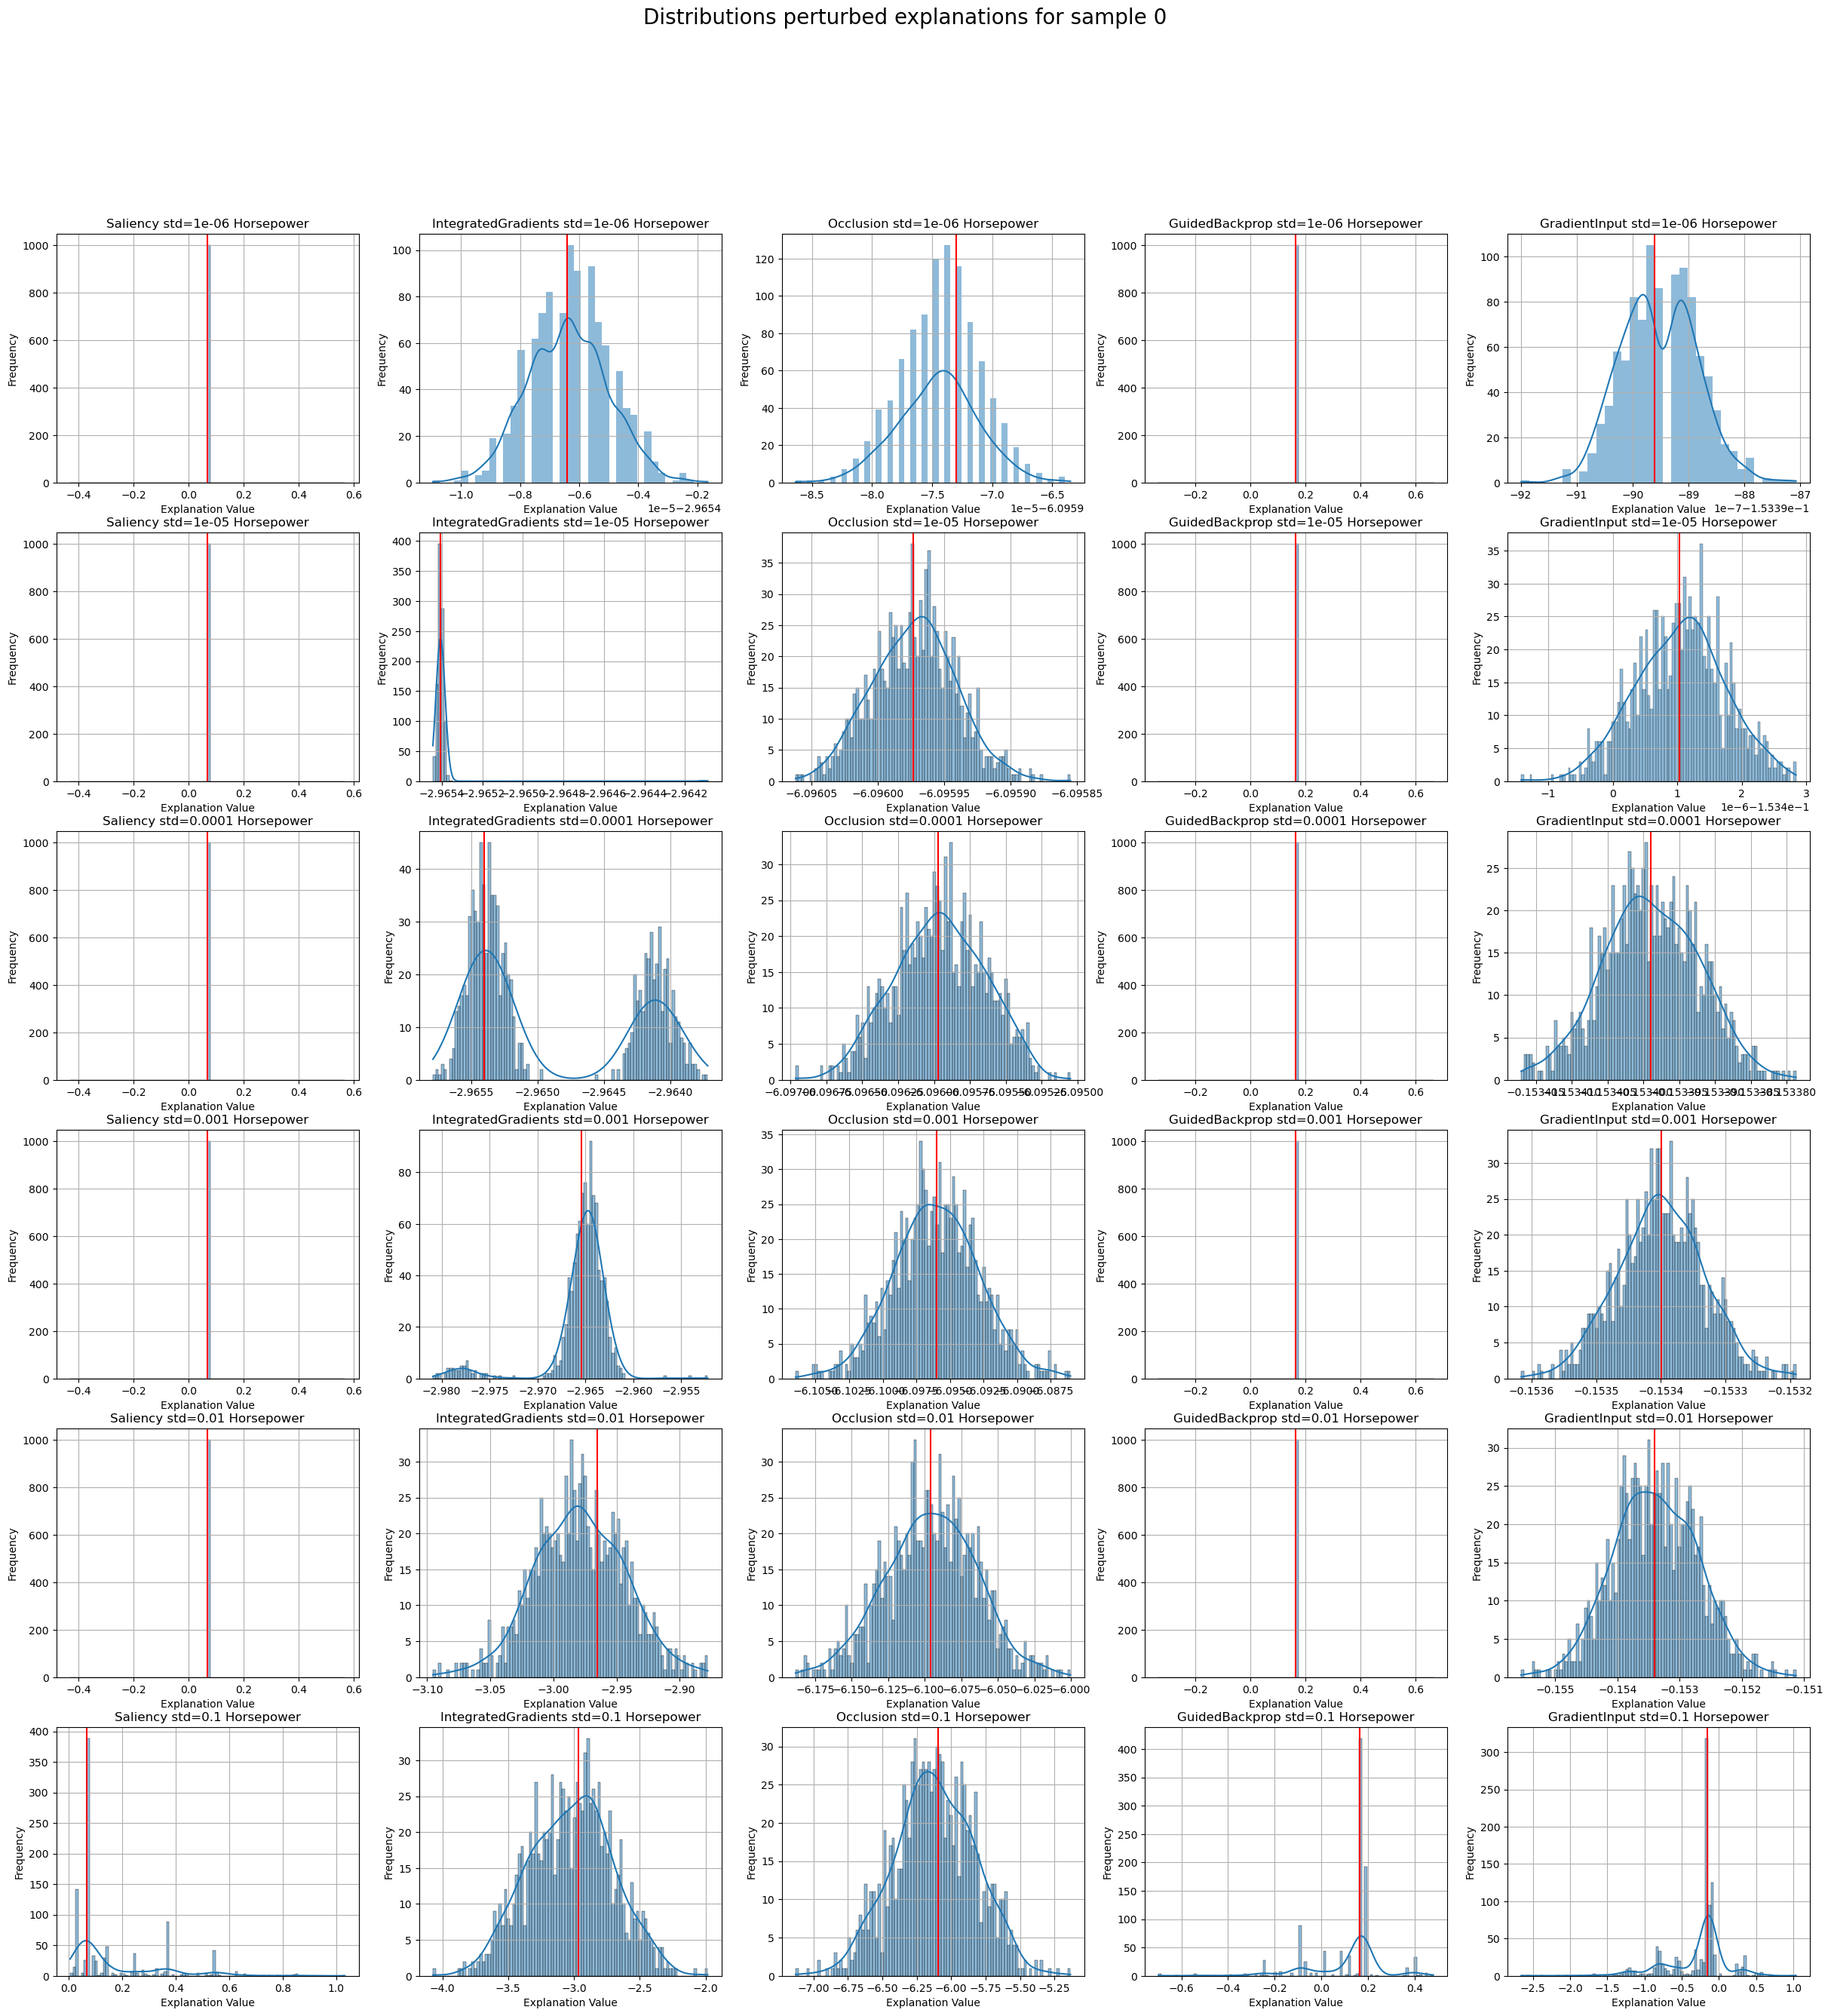

In [52]:
# Plot histogram and Kernel Density Estimate (KDE)
sample_id, feature_id = 0, 2
fig = plt.figure(figsize=(30, 30))
fig.suptitle('Distributions perturbed explanations for sample ' + str(sample_id), fontsize=20)
for i, exp_name in enumerate(empirical_exps[sample_id]): 
    for j, std in enumerate(stds):
        plt.subplot(6,5,5*j+i+1)
        sns.histplot(empirical_exps[sample_id][exp_name][std][:,0,feature_id], kde=True, bins=100)
        plt.axvline(x=unperturbed_exps[sample_id][exp_name][0][feature_id], color='r')#, label='axvline - full height')
        plt.title(exp_name + ' std=' + str(std) + ' ' + features_name[feature_id])
        plt.xlabel("Explanation Value")
        plt.ylabel("Frequency")
        plt.grid()
plt.show()

c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\

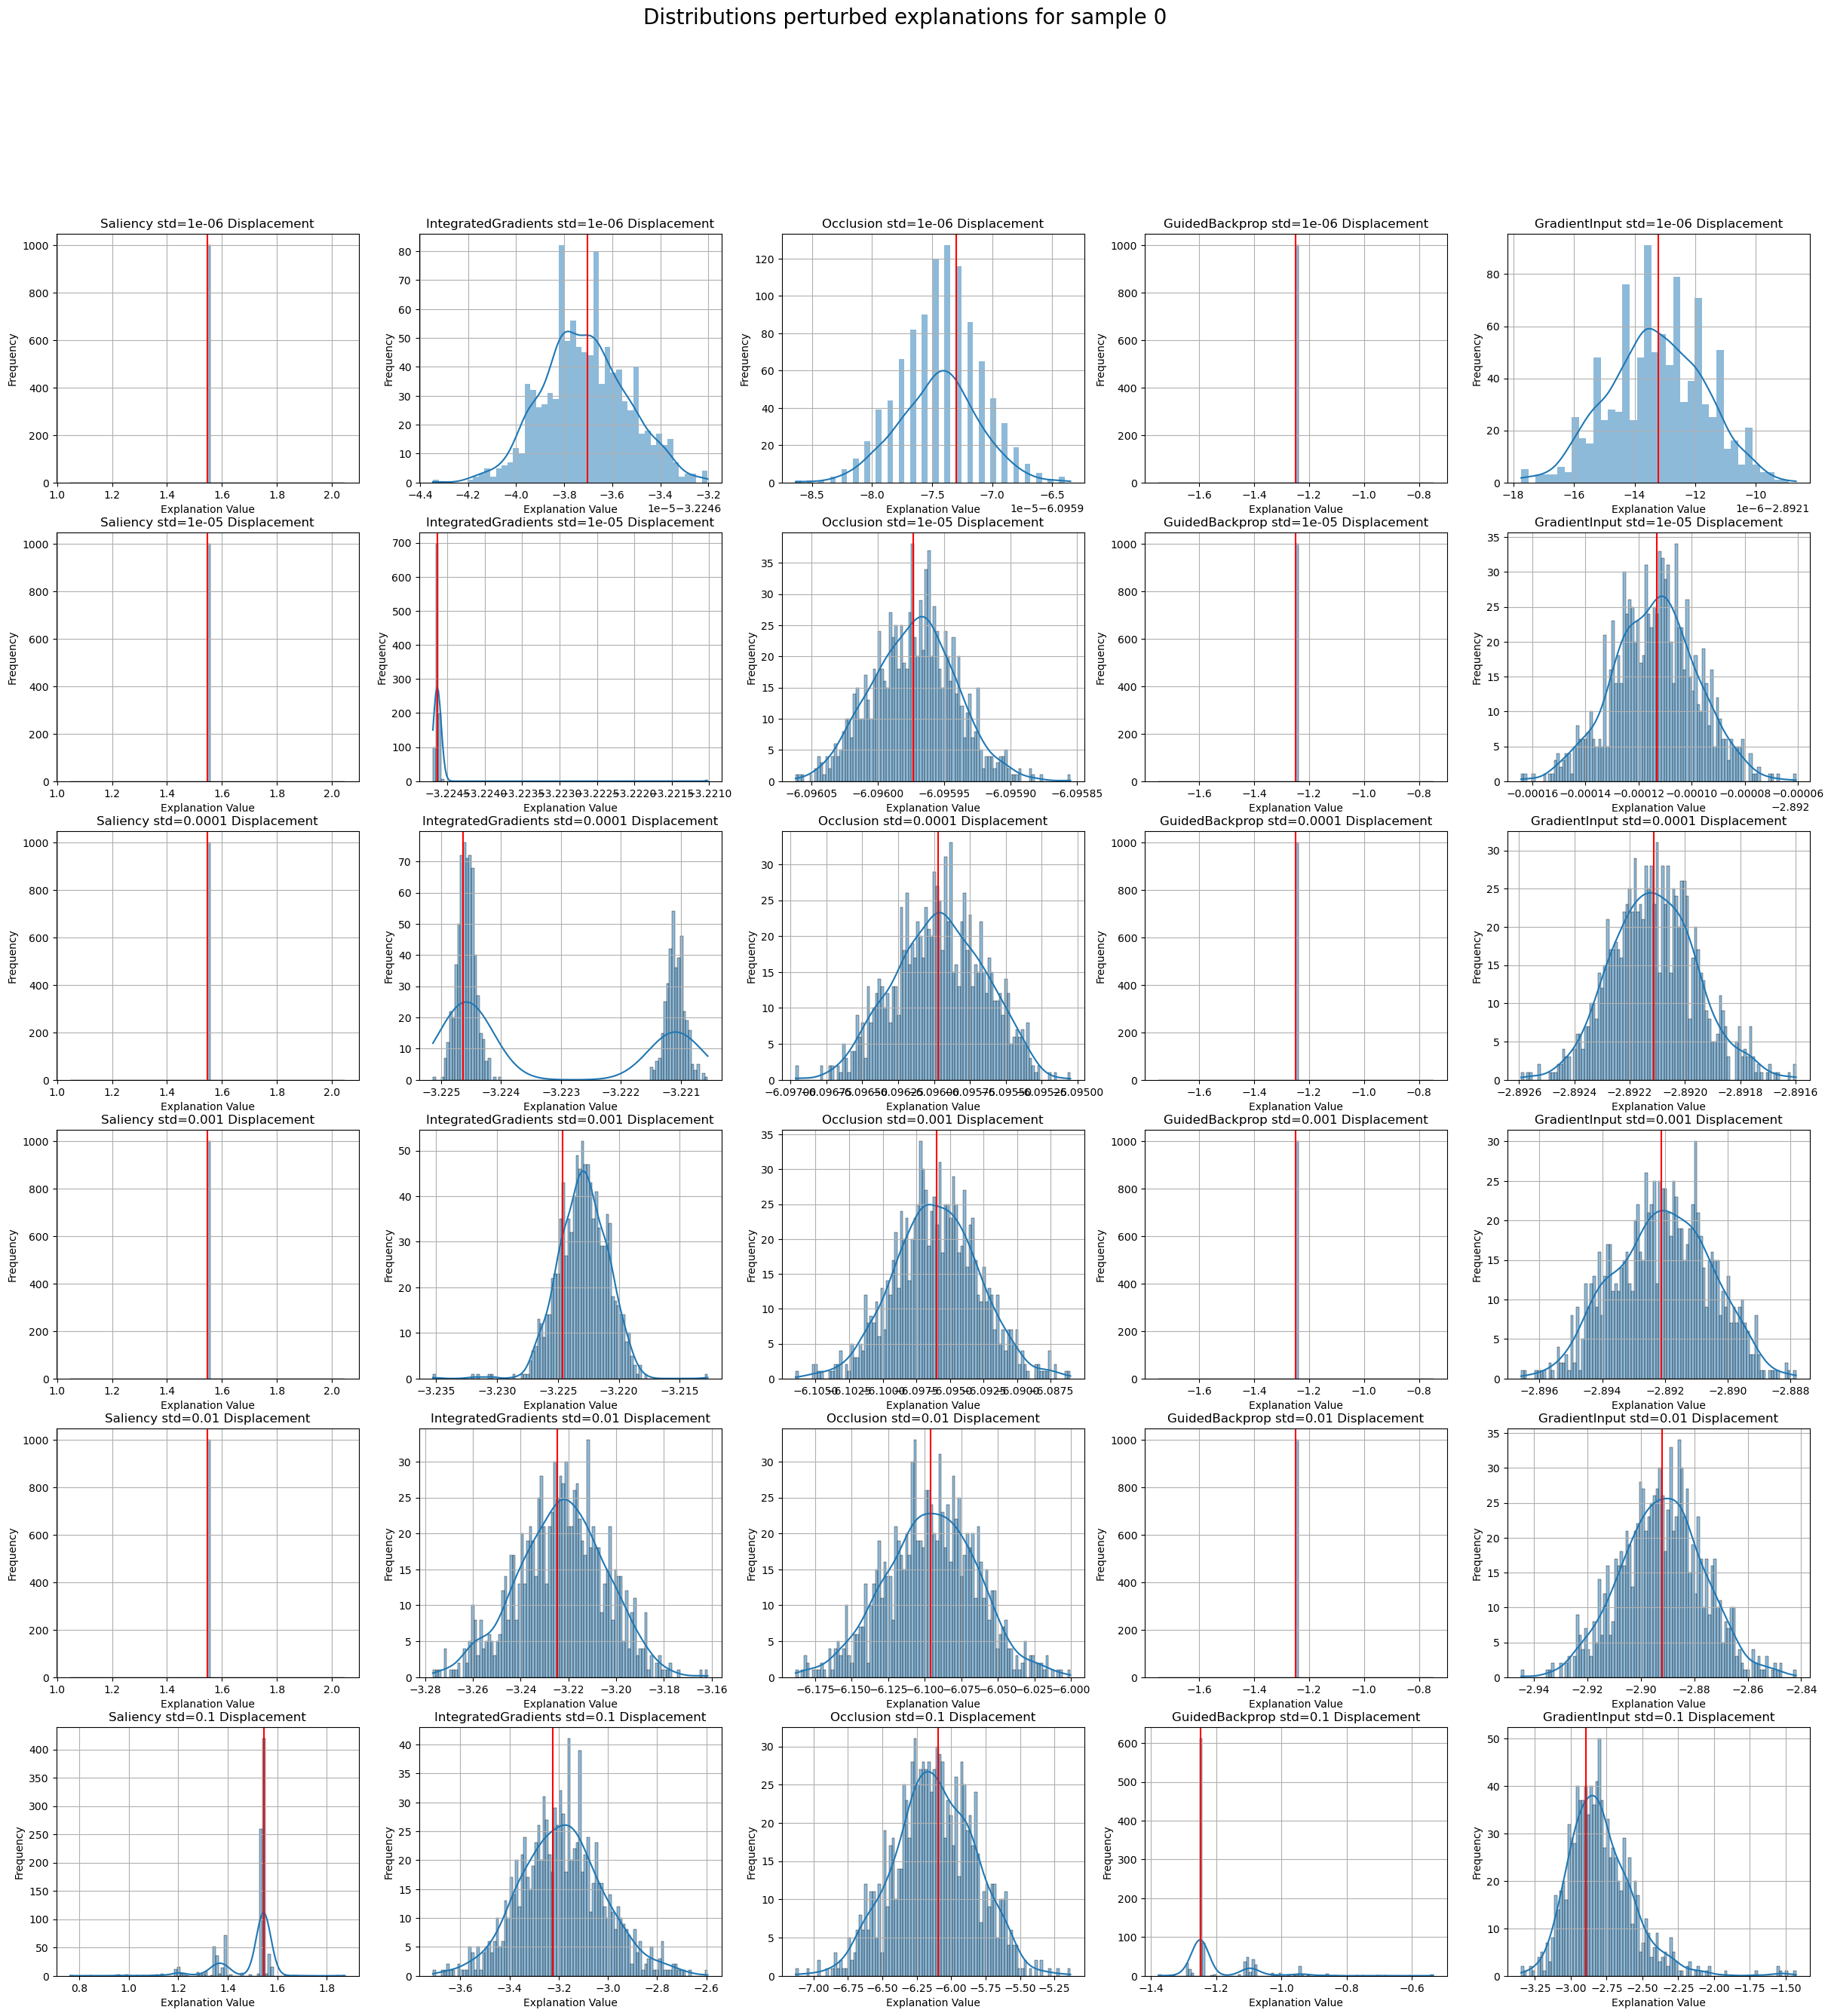

In [53]:
# Plot histogram and Kernel Density Estimate (KDE)
sample_id, feature_id = 0, 1
fig = plt.figure(figsize=(30, 30))
fig.suptitle('Distributions perturbed explanations for sample ' + str(sample_id), fontsize=20)
for i, exp_name in enumerate(empirical_exps[sample_id]): 
    for j, std in enumerate(stds):
        plt.subplot(6,5,5*j+i+1)
        sns.histplot(empirical_exps[sample_id][exp_name][std][:,0,feature_id], kde=True, bins=100)
        plt.axvline(x=unperturbed_exps[sample_id][exp_name][0][feature_id], color='r')#, label='axvline - full height')
        plt.title(exp_name + ' std=' + str(std) + ' ' + features_name[feature_id])
        plt.xlabel("Explanation Value")
        plt.ylabel("Frequency")
        plt.grid()
plt.show()

c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\

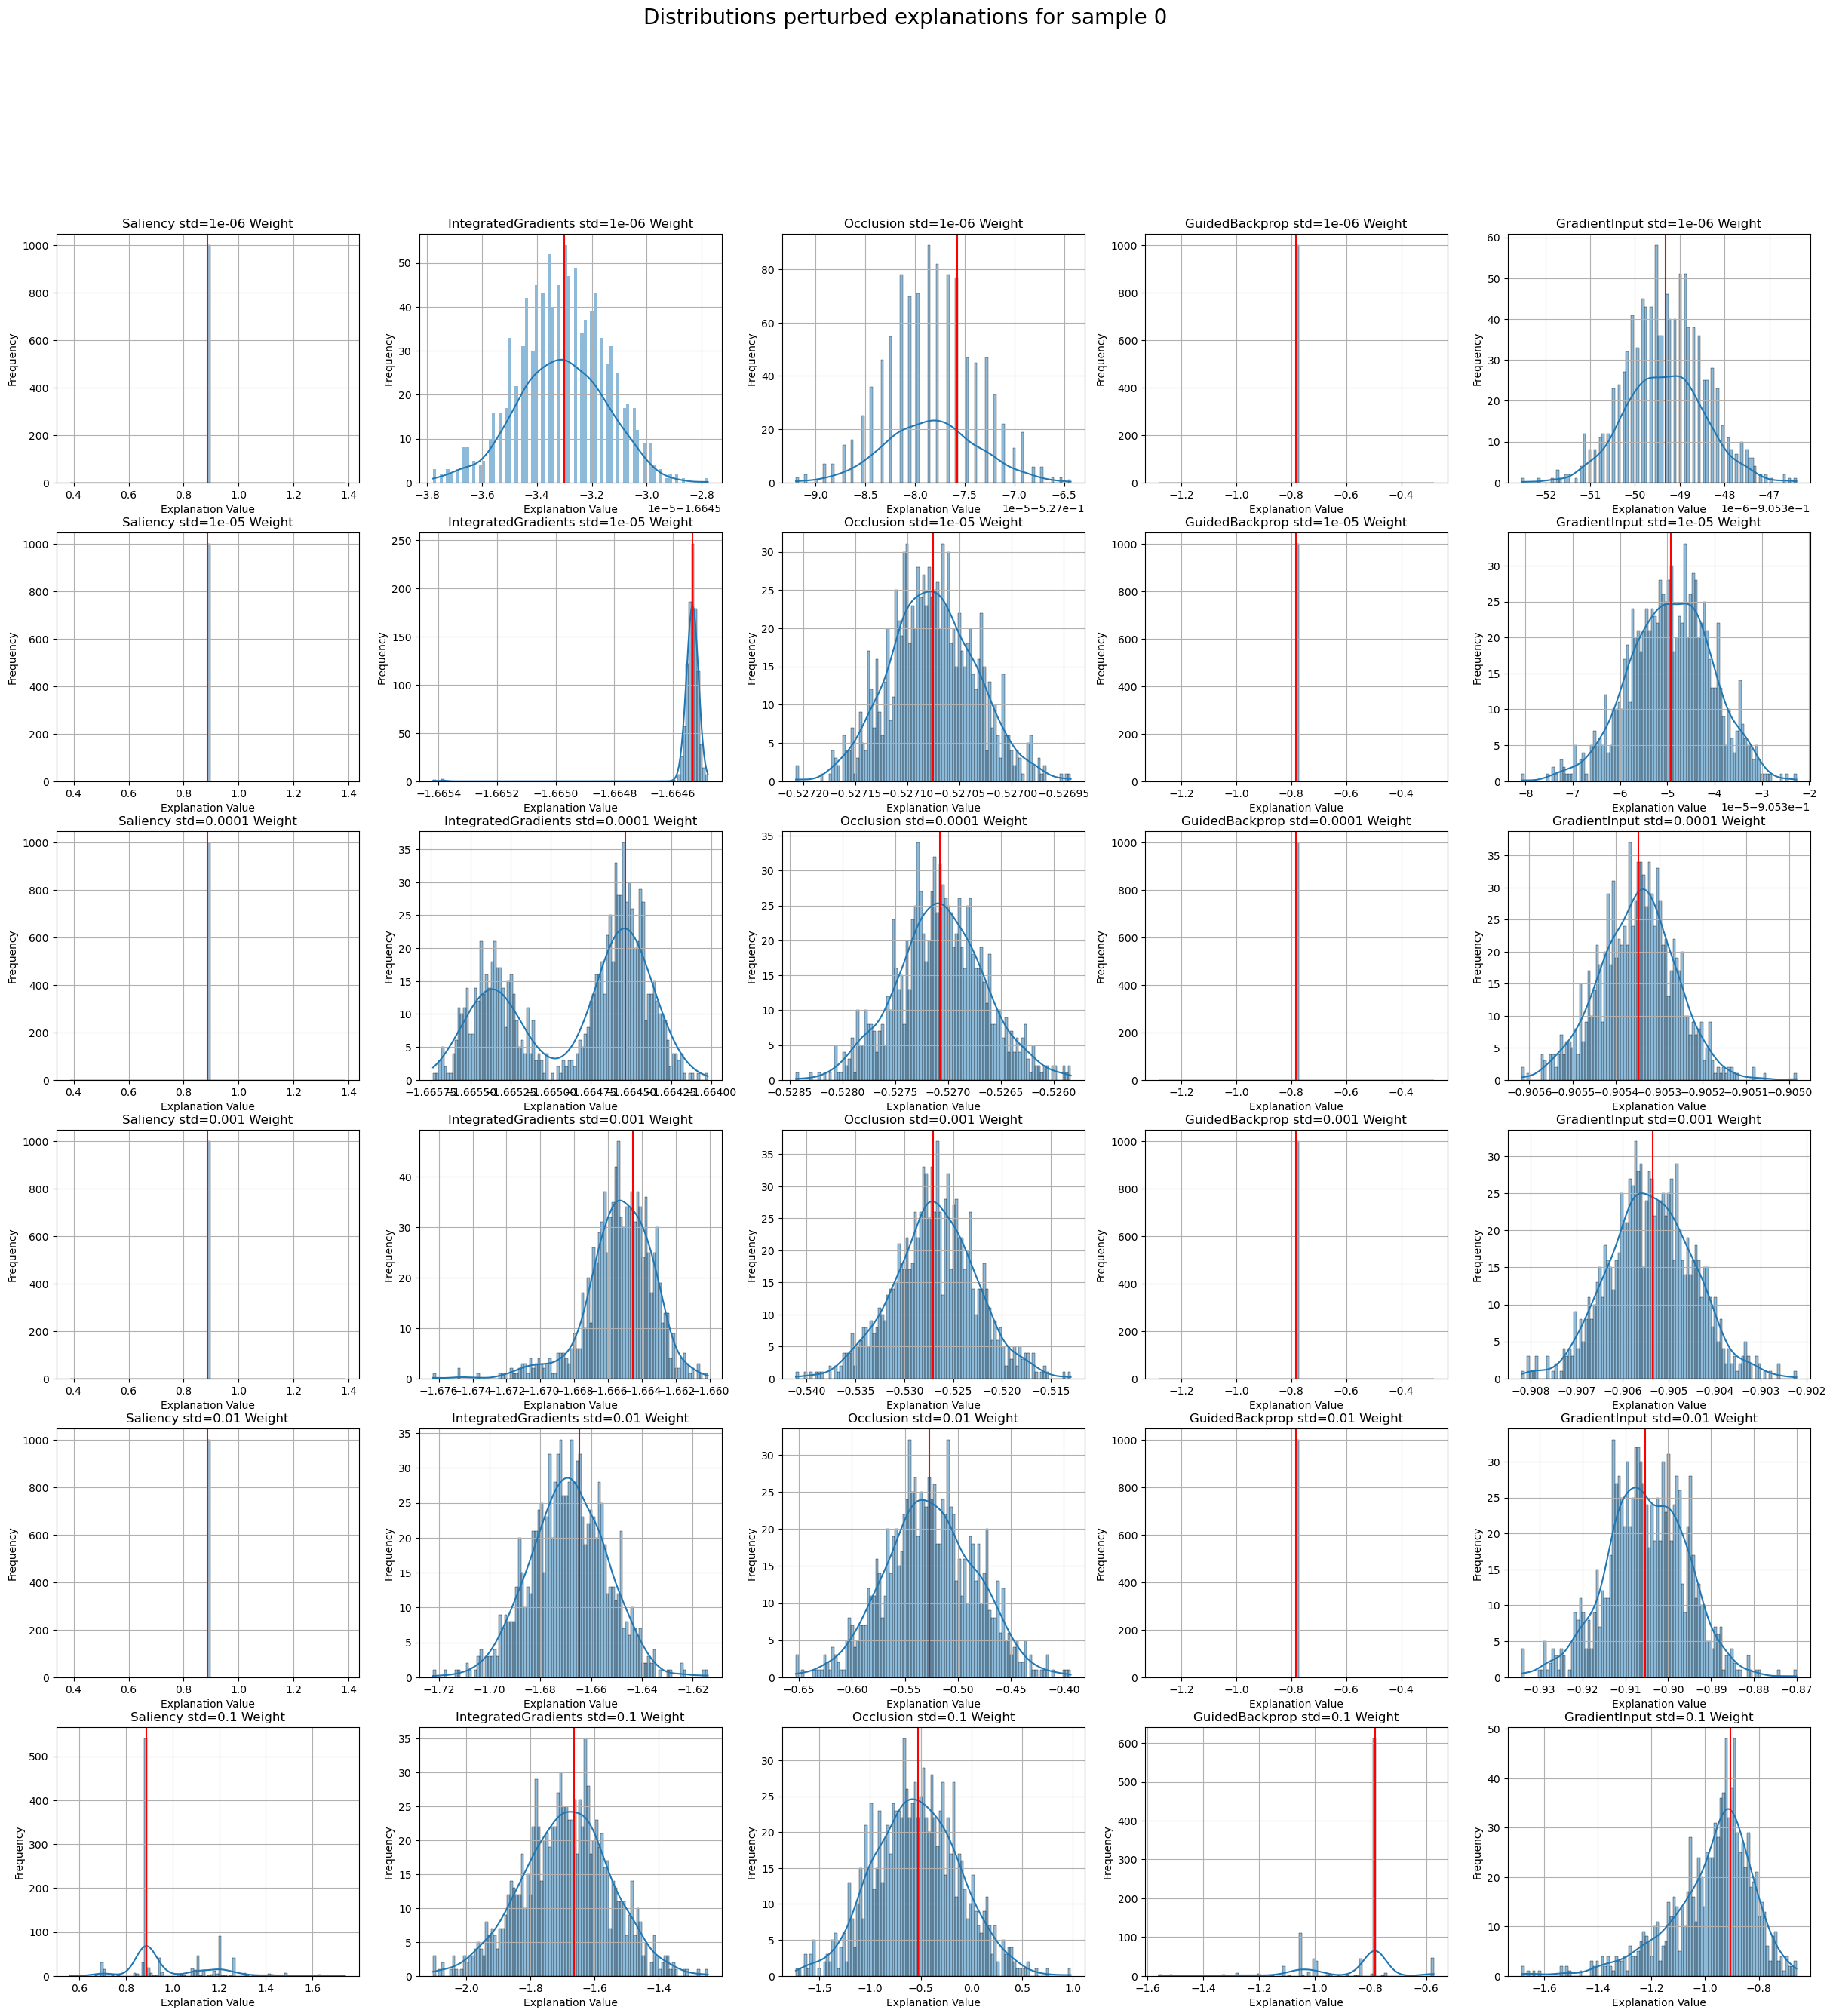

In [54]:
# Plot histogram and Kernel Density Estimate (KDE)
sample_id, feature_id = 0, 3
fig = plt.figure(figsize=(30, 30))
fig.suptitle('Distributions perturbed explanations for sample ' + str(sample_id), fontsize=20)
for i, exp_name in enumerate(empirical_exps[sample_id]): 
    for j, std in enumerate(stds):
        plt.subplot(6,5,5*j+i+1)
        sns.histplot(empirical_exps[sample_id][exp_name][std][:,0,feature_id], kde=True, bins=100)
        plt.axvline(x=unperturbed_exps[sample_id][exp_name][0][feature_id], color='r')#, label='axvline - full height')
        plt.title(exp_name + ' std=' + str(std) + ' ' + features_name[feature_id])
        plt.xlabel("Explanation Value")
        plt.ylabel("Frequency")
        plt.grid()
plt.show()

c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\

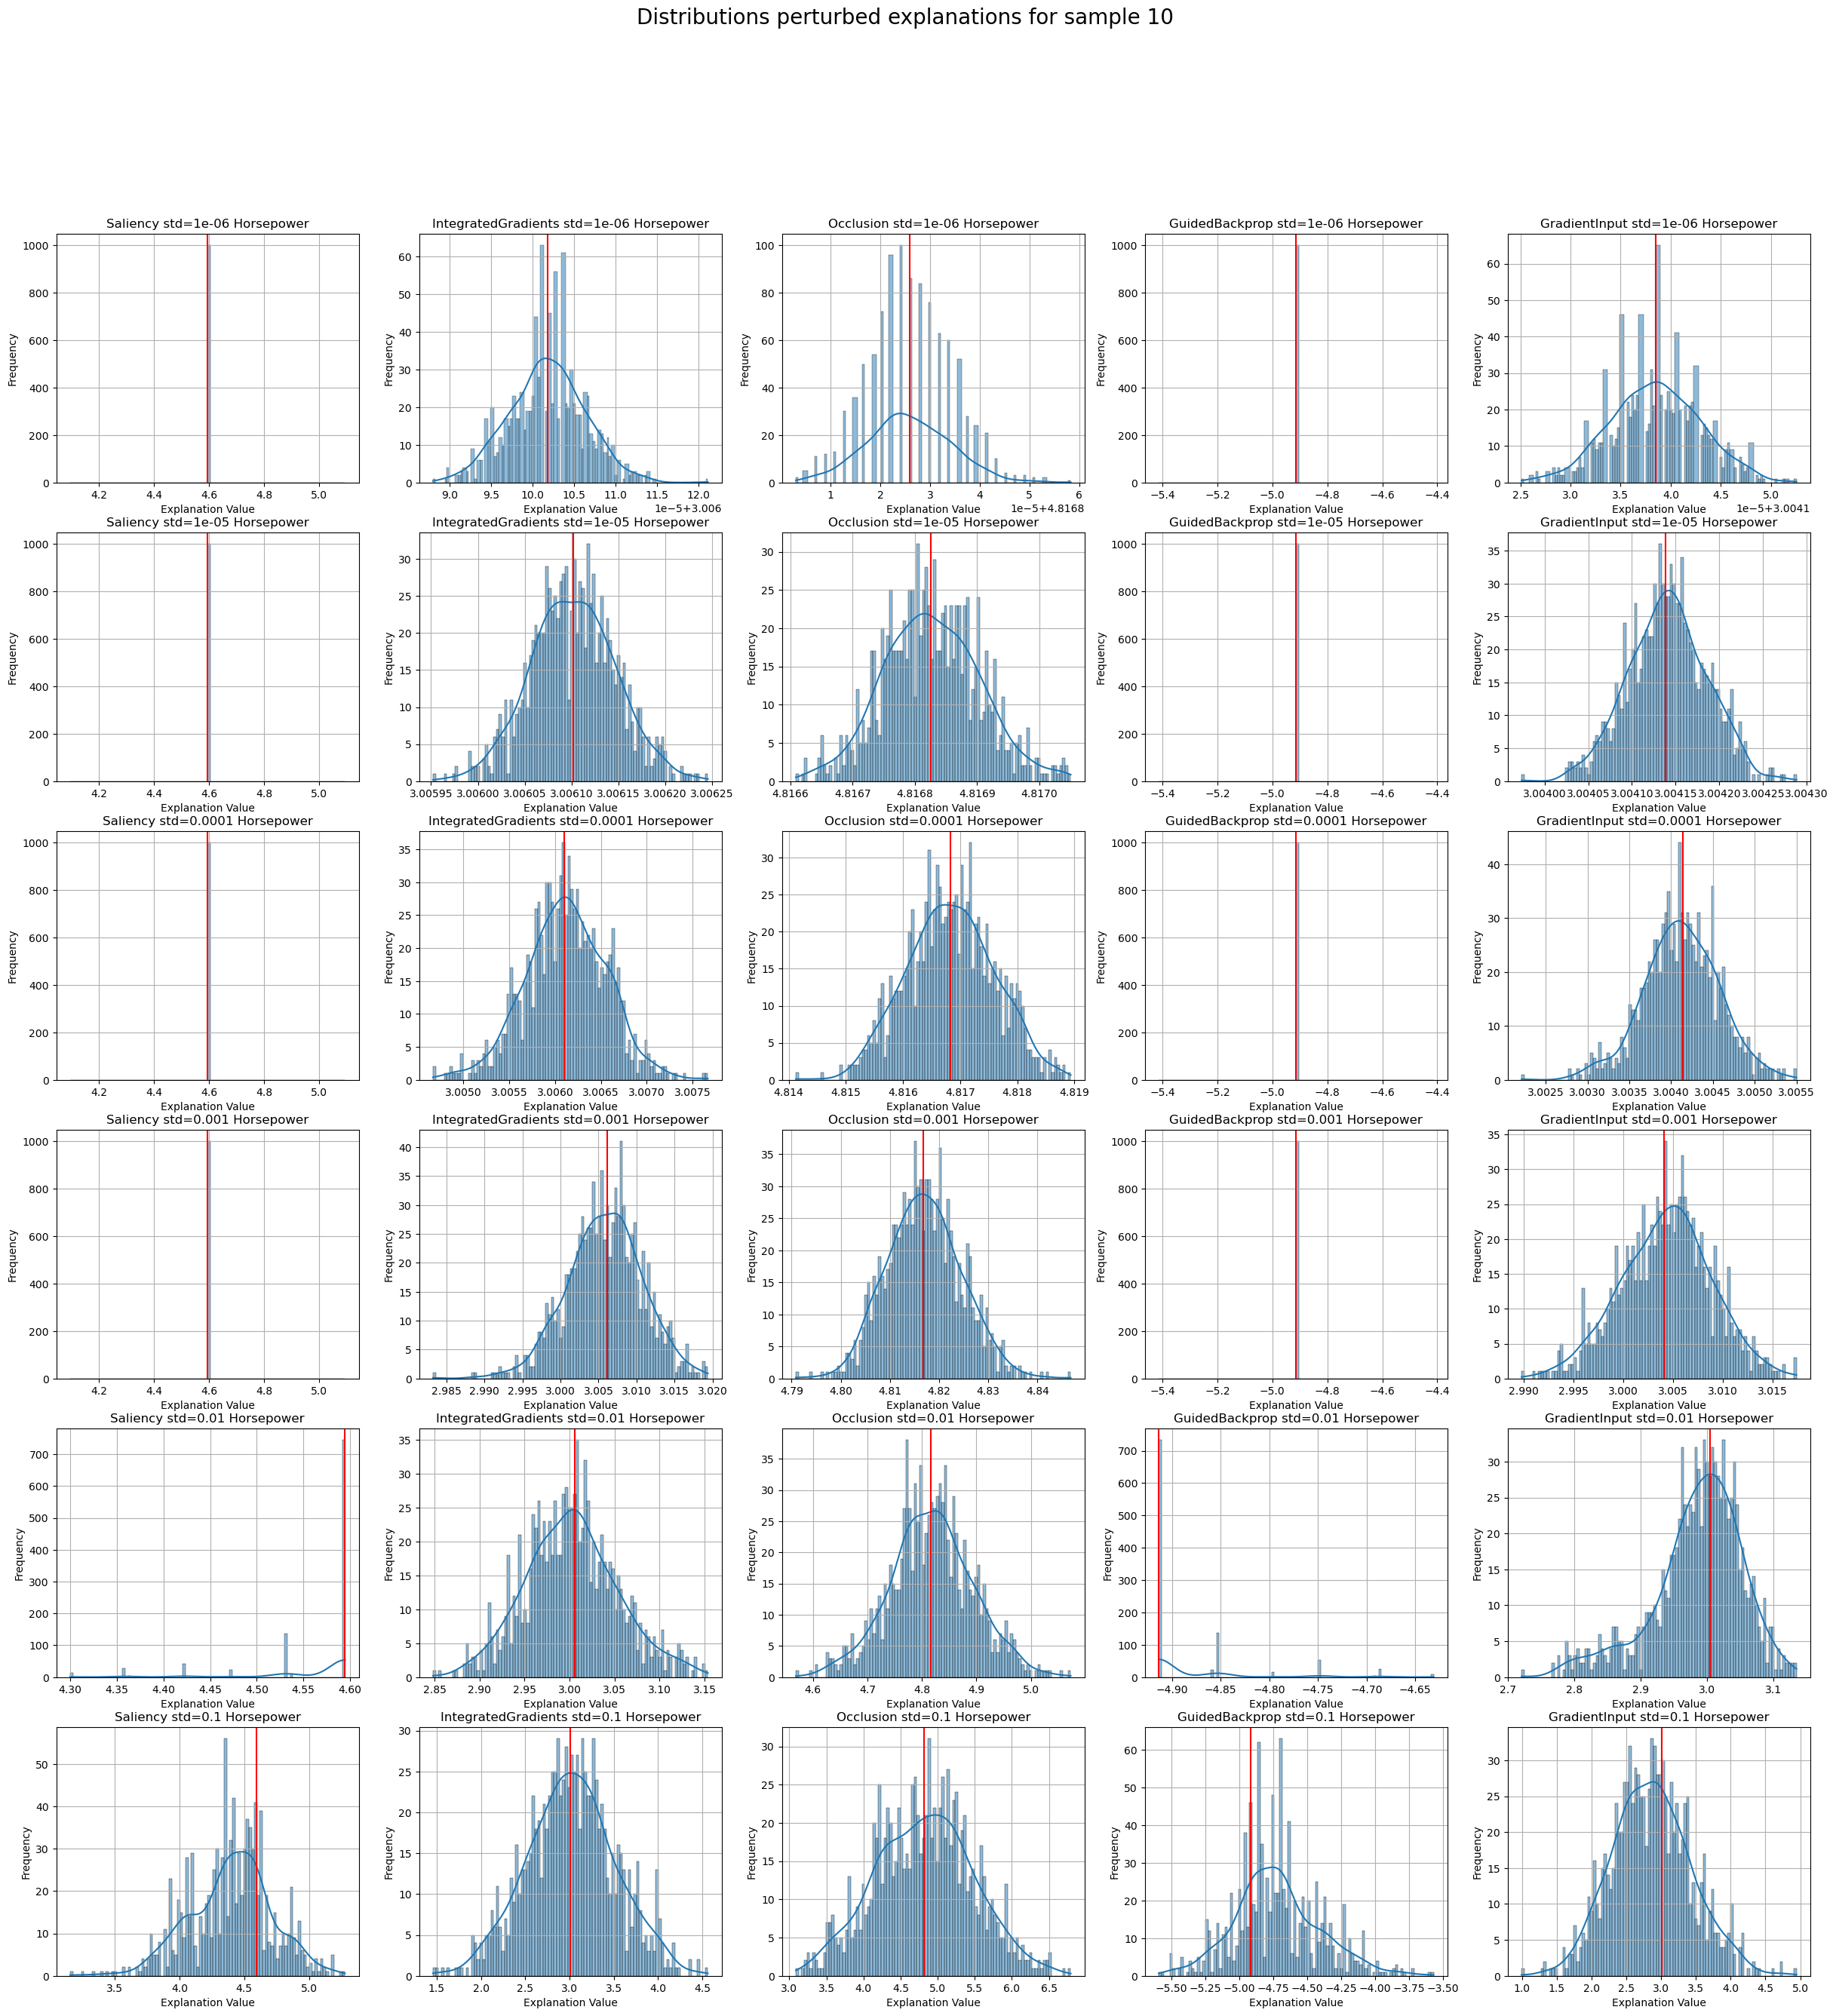

In [55]:
# Plot histogram and Kernel Density Estimate (KDE)
sample_id, feature_id = 10, 2
fig = plt.figure(figsize=(30, 30))
fig.suptitle('Distributions perturbed explanations for sample ' + str(sample_id), fontsize=20)
for i, exp_name in enumerate(empirical_exps[sample_id]): 
    for j, std in enumerate(stds):
        plt.subplot(6,5,5*j+i+1)
        sns.histplot(empirical_exps[sample_id][exp_name][std][:,0,feature_id], kde=True, bins=100)
        plt.axvline(x=unperturbed_exps[sample_id][exp_name][0][feature_id], color='r')#, label='axvline - full height')
        plt.title(exp_name + ' std=' + str(std) + ' ' + features_name[feature_id])
        plt.xlabel("Explanation Value")
        plt.ylabel("Frequency")
        plt.grid()
plt.show()

c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\

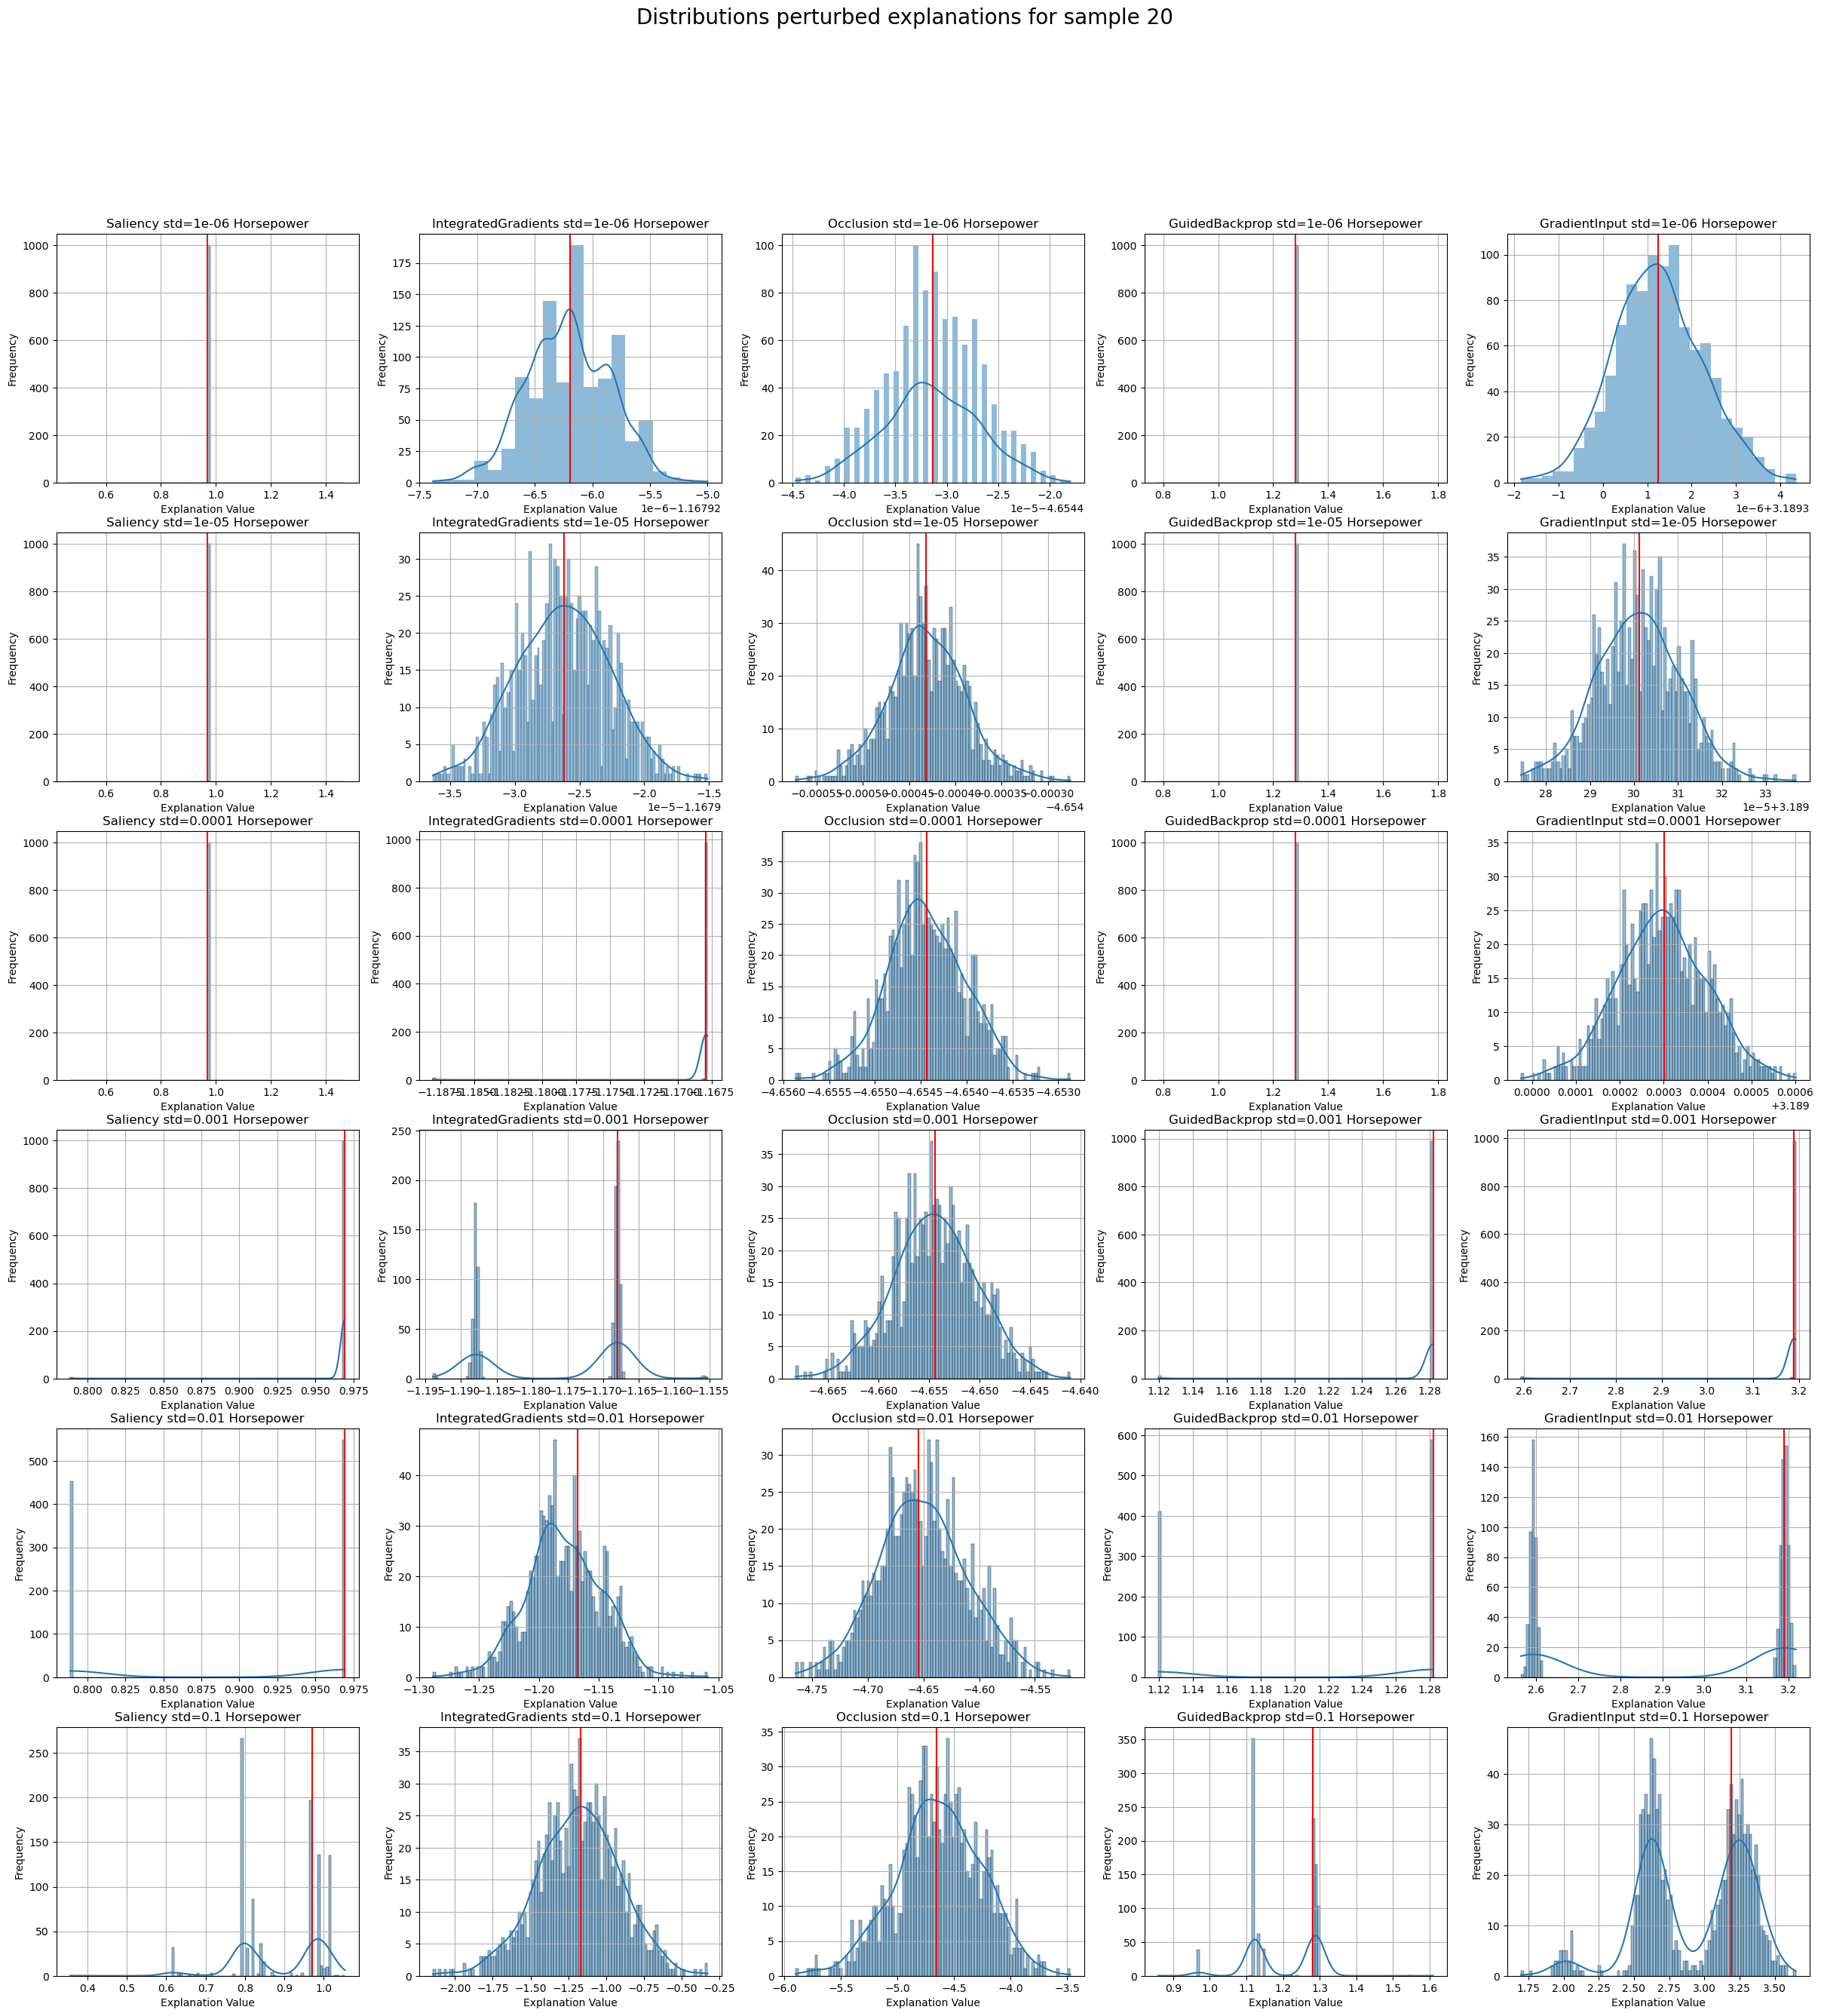

In [56]:
# Plot histogram and Kernel Density Estimate (KDE)
sample_id, feature_id = 20, 2
fig = plt.figure(figsize=(30, 30))
fig.suptitle('Distributions perturbed explanations for sample ' + str(sample_id), fontsize=20)
for i, exp_name in enumerate(empirical_exps[sample_id]): 
    for j, std in enumerate(stds):
        plt.subplot(6,5,5*j+i+1)
        sns.histplot(empirical_exps[sample_id][exp_name][std][:,0,feature_id], kde=True, bins=100)
        plt.axvline(x=unperturbed_exps[sample_id][exp_name][0][feature_id], color='r')#, label='axvline - full height')
        plt.title(exp_name + ' std=' + str(std) + ' ' + features_name[feature_id])
        plt.xlabel("Explanation Value")
        plt.ylabel("Frequency")
        plt.grid()
plt.show()

c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\

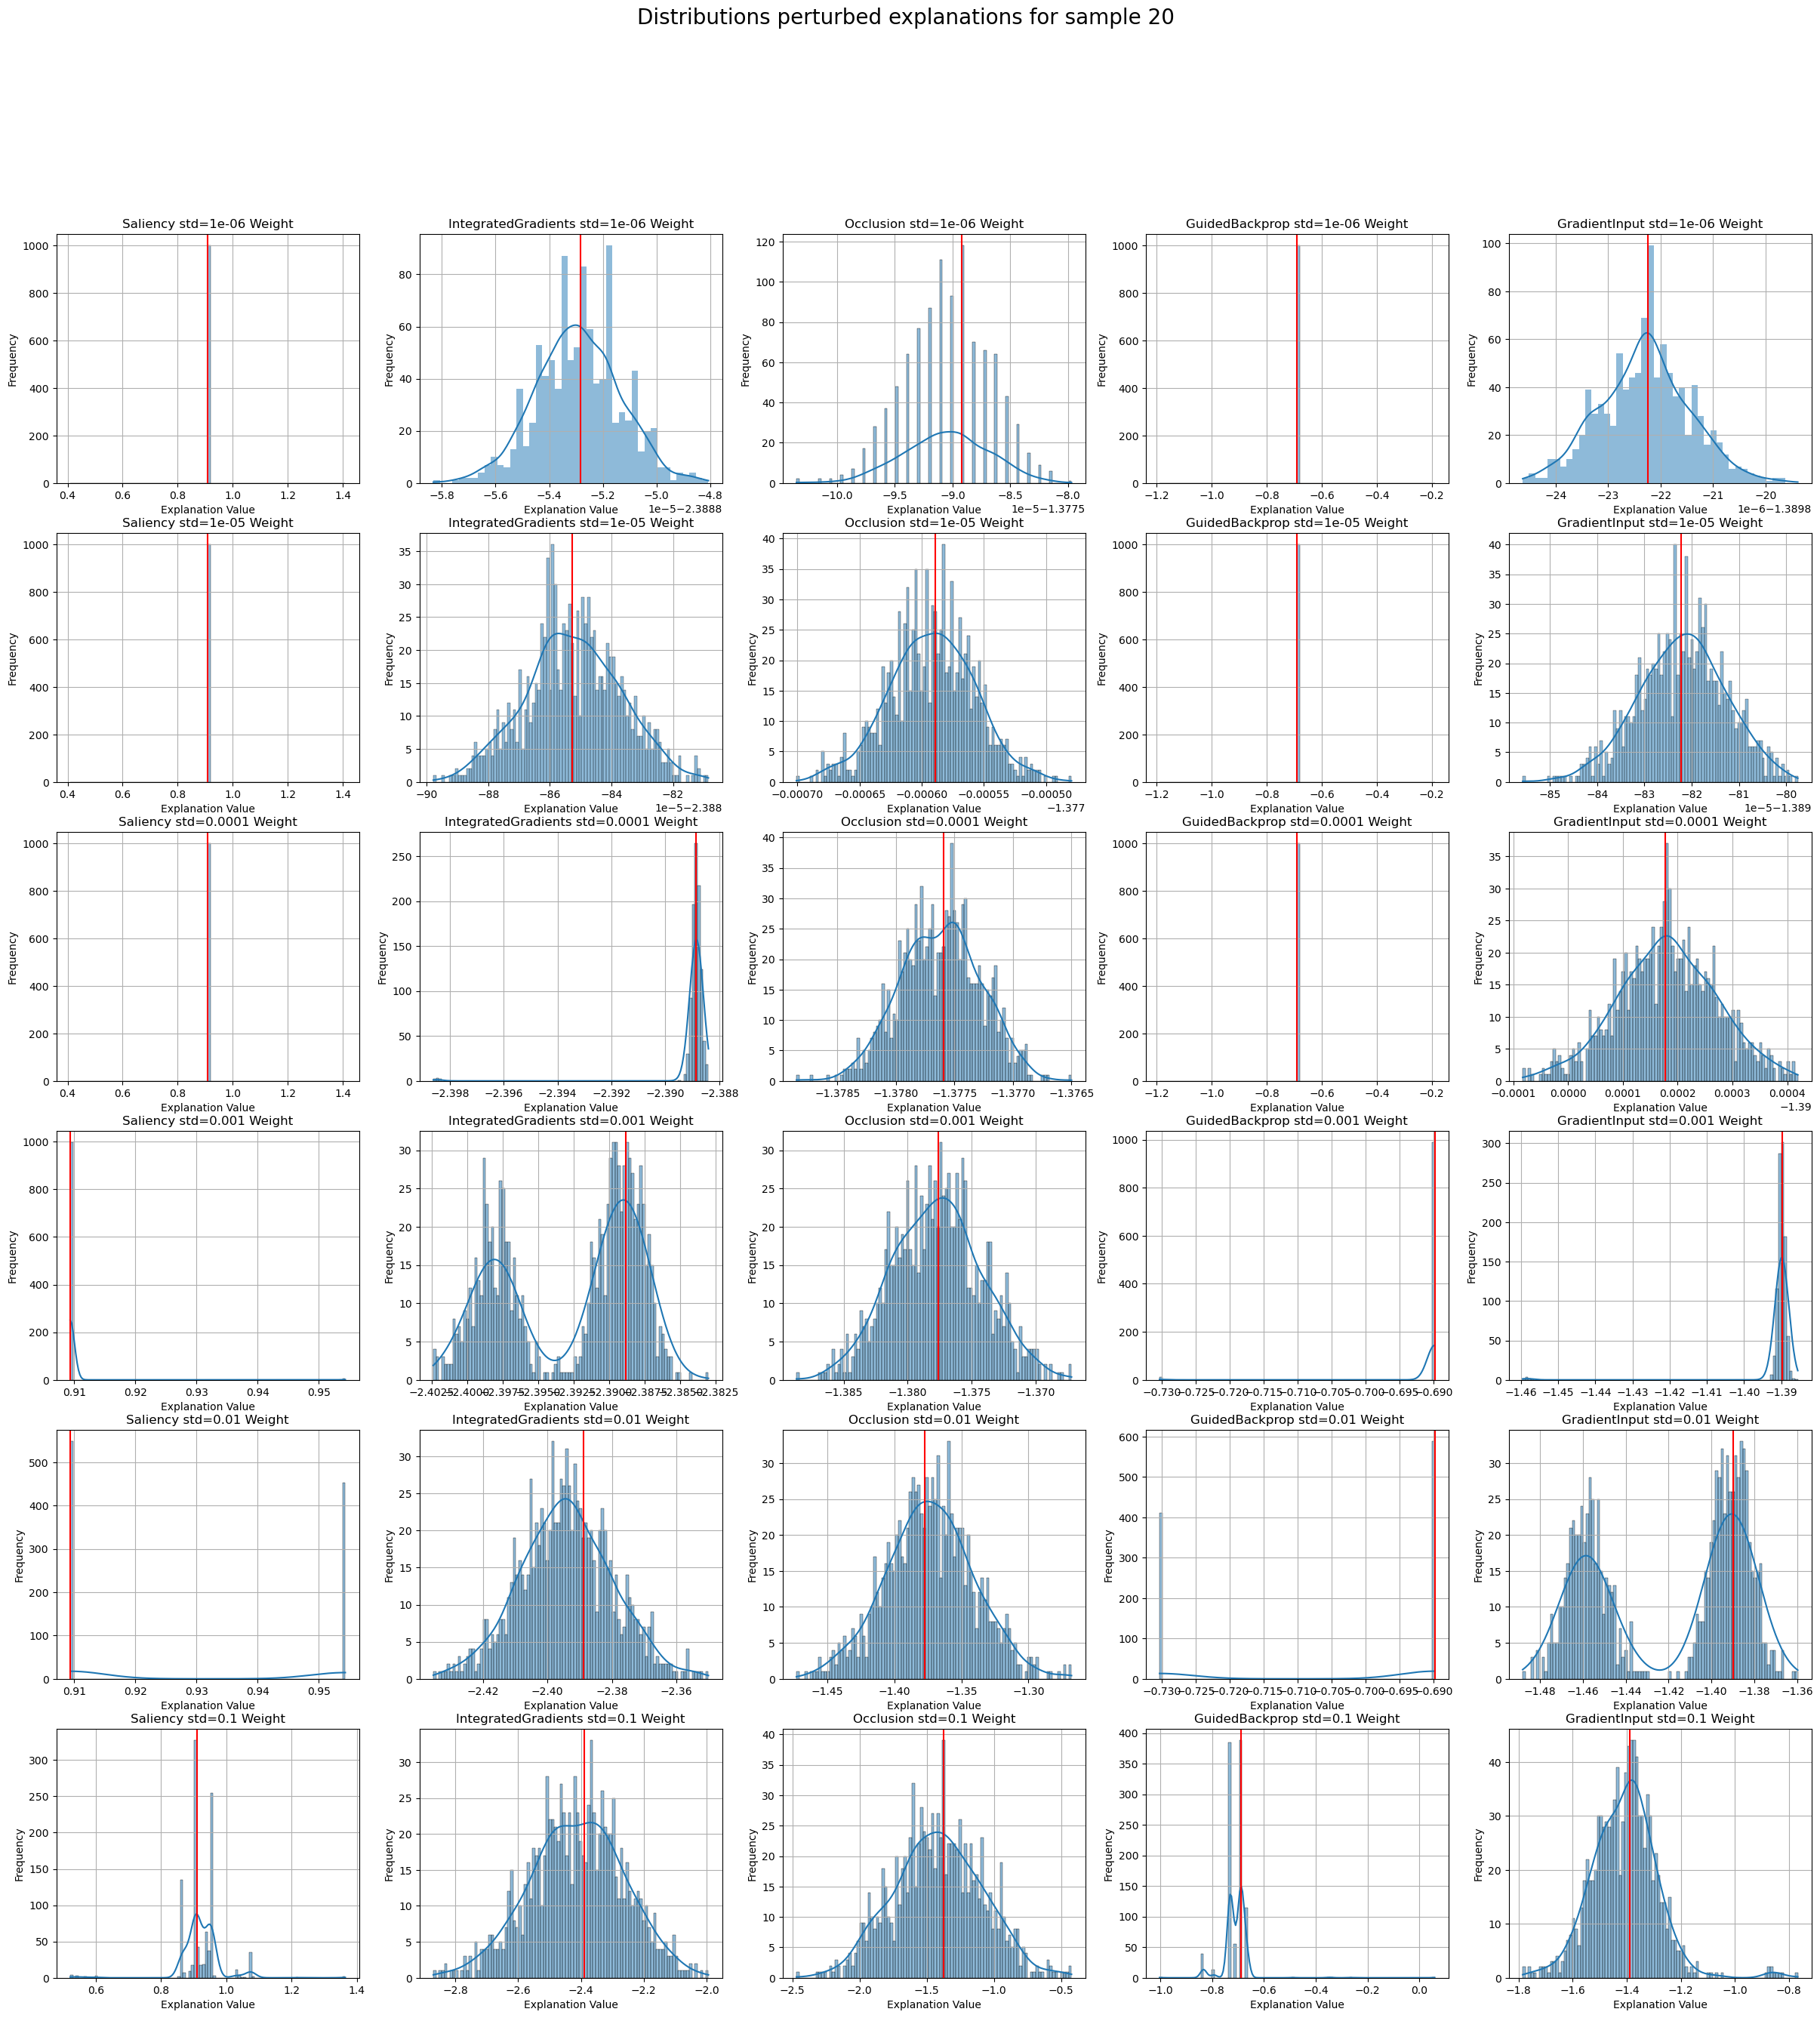

In [57]:
# Plot histogram and Kernel Density Estimate (KDE)
sample_id, feature_id = 20, 3
fig = plt.figure(figsize=(30, 30))
fig.suptitle('Distributions perturbed explanations for sample ' + str(sample_id), fontsize=20)
for i, exp_name in enumerate(empirical_exps[sample_id]): 
    for j, std in enumerate(stds):
        plt.subplot(6,5,5*j+i+1)
        sns.histplot(empirical_exps[sample_id][exp_name][std][:,0,feature_id], kde=True, bins=100)
        plt.axvline(x=unperturbed_exps[sample_id][exp_name][0][feature_id], color='r')#, label='axvline - full height')
        plt.title(exp_name + ' std=' + str(std) + ' ' + features_name[feature_id])
        plt.xlabel("Explanation Value")
        plt.ylabel("Frequency")
        plt.grid()
plt.show()

##### Deprecated: QQ-plots and statistical tests

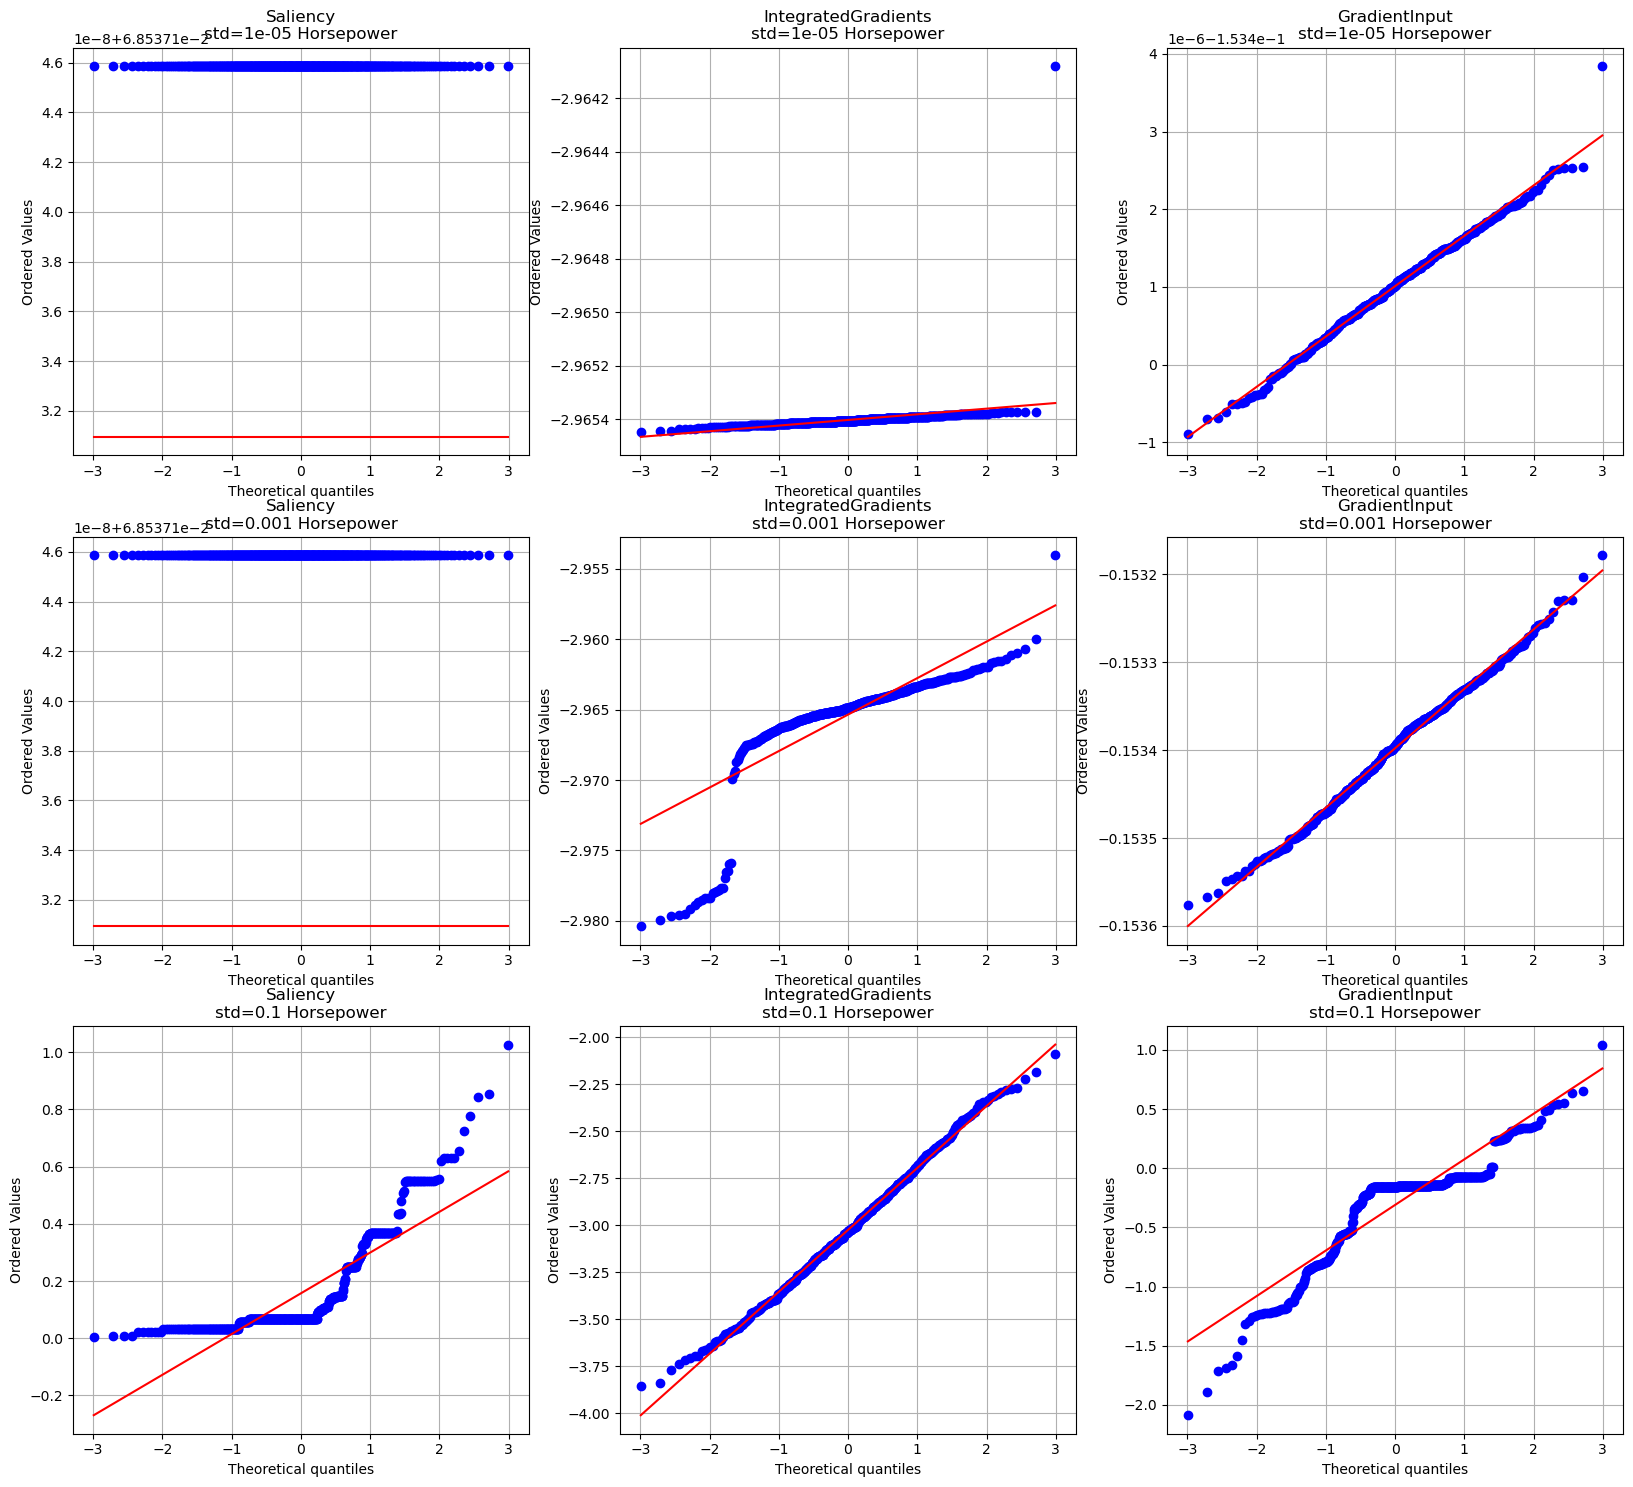

In [18]:
import scipy.stats as stats

# Generate Q-Q plot
plt.figure(figsize=(20, 18))
for i, exp_name in enumerate(empirical_exps): 
    for j, std in enumerate(stds):
        plt.subplot(3,3,3*j+i+1)
        stats.probplot(empirical_exps[exp_name][std][:,0,feature_id], dist="norm", plot=plt)
        plt.title(exp_name + '\nstd=' + str(std) + ' ' + features_name[feature_id])
        plt.grid()
plt.show()

In [21]:
from scipy.stats import ks_1samp, norm

for i, exp_name in enumerate(empirical_exps): 
    for std in stds:
        # Normalize data (mean 0, std 1) to compare with standard normal distribution
        flat_exp = empirical_exps[exp_name][std][:,0,feature_id]
        standardized_exp = (flat_exp - np.mean(flat_exp)) / np.std(flat_exp)

        # Perform K-S test
        stat, p_value = ks_1samp(standardized_exp, norm.cdf)
        print('\n' + exp_name + ' std=' + str(std) + ' ' + features_name[feature_id])
        print("Kolmogorov-Smirnov test statistic:", stat)
        print("p-value:", p_value)

        if p_value > 0.05:
            print("Fail to reject null hypothesis: Explanations may be normally distributed.")
        else:
            print("Reject null hypothesis: Explanations are not normally distributed.")


Saliency std=1e-06 Horsepower
Kolmogorov-Smirnov test statistic: nan
p-value: nan
Reject null hypothesis: Explanations are not normally distributed.

Saliency std=0.1 Horsepower
Kolmogorov-Smirnov test statistic: 0.2994663571740984
p-value: 0.00017946145571858213
Reject null hypothesis: Explanations are not normally distributed.

IntegratedGradients std=1e-06 Horsepower
Kolmogorov-Smirnov test statistic: 0.2
p-value: 0.03143877776953241
Reject null hypothesis: Explanations are not normally distributed.

IntegratedGradients std=0.1 Horsepower
Kolmogorov-Smirnov test statistic: 0.11402289278529398
p-value: 0.49821394181437273
Fail to reject null hypothesis: Explanations may be normally distributed.

GradientInput std=1e-06 Horsepower
Kolmogorov-Smirnov test statistic: 0.13697291864637995
p-value: 0.2789766847877695
Fail to reject null hypothesis: Explanations may be normally distributed.

GradientInput std=0.1 Horsepower
Kolmogorov-Smirnov test statistic: 0.31316221927455934
p-value: 7.

C:\Users\teo_c\AppData\Local\Temp\ipykernel_21204\1450597179.py:7: RuntimeWarning: invalid value encountered in true_divide
  standardized_exp = (flat_exp - np.mean(flat_exp)) / np.std(flat_exp)
